In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib import gridspec
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
from ipywidgets import interact, widgets, fixed
from IPython.display import display
from scipy.signal import savgol_filter
import pickle
import ast
import os
import shutil
import itertools
import shap

In [2]:
# Add the python path to the folder containing some custom packages.
import sys
sys.path.insert(0, "../../packages/")
from TsIP.TsIP import TsIP
from LagsCreator.LagsCreator import LagsCreator
from NestedCV.NestedCV import NestedCV

In [3]:
# Create the folder where to store the information arising from this notebook.
dir_output_test = "./output_test"
if not os.path.exists(dir_output_test):
    os.makedirs(dir_output_test)

In [4]:
# Define the path of the folder containing the information of the hyperparameter tuning.
dir_hyper_params = "./output_hyperparameter_tuning/"
# Load the values of some global variables.
with open(dir_hyper_params + "global_variables", "rb") as f:
    COUNTRIES_TO_CONSIDER, TEST_SIZE, FRACTION_TRAIN_SET = pickle.load(f)

In [5]:
# Define variable to predict (according to the variable in the 'creator_train_test' notebook).
# We have to rename the indicator 'FCG <= 2' to 'FCG'.
TARGET = "FCG"
# Define the total number of splits (according to the splits in the 'creator_train_test' notebook).
TOTAL_SPLITS = 3

In [6]:
# Define the main folder containing the training and test data.
dir_data = "./data_xgboost"

## Time-series dataset

In [7]:
# Load the data of the Yemen country.
df_yemen = pd.read_csv("../../Dataset time-series/output_data/Yemen/Yemen.csv", header = [0, 1], index_col = 0)
df_yemen.index.name = "Datetime"
df_yemen.index = pd.to_datetime(df_yemen.index)
freq = "D"
df_yemen.index.freq = freq
df_yemen.columns = pd.MultiIndex.from_tuples(map(lambda x: ("Yemen", x[0], x[1]), df_yemen.columns), names = ["Country", "AdminStrata", "Indicator"])

In [8]:
df_yemen.drop("Exchange rate", axis = 1, level = 2, inplace = True)

In [9]:
# Load the time-series data of the Nigeria country.
df_nigeria = pd.read_csv("../../Dataset time-series/output_data/Nigeria/Nigeria.csv", header = [0, 1], index_col = 0)
df_nigeria.index.name = "Datetime"
df_nigeria.index = pd.to_datetime(df_nigeria.index)
freq = "D"
df_nigeria.index.freq = freq
df_nigeria.columns = pd.MultiIndex.from_tuples(map(lambda x: ("Nigeria", x[0], x[1]), df_nigeria.columns), names = ["Country", "AdminStrata", "Indicator"])

In [10]:
# Concatenate data.
df = pd.concat([df_yemen, df_nigeria], axis = 1)
# Consider the following dates (according to the range in the 'creator_train_test' notebook).
df = df.loc["2018-01-01":"2020-08-31"]
# We have to rename the indicator 'FCG <= 2' to 'FCG' and 'rCSI >= 19' to 'rCSI' (XGBoost issue).
df.rename({"FCG <= 2": "FCG", "rCSI >= 19": "rCSI"}, axis = 1, level = 2, inplace = True)

In [11]:
# Select countries.
df = df[COUNTRIES_TO_CONSIDER]
df.head()

Country                             Yemen                                      \
AdminStrata                         Abyan                                       
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%) Code   
Datetime                                                                        
2018-01-01                            NaN                            NaN   65   
2018-01-02                            NaN                            NaN   65   
2018-01-03                            NaN                            NaN   65   
2018-01-04                            NaN                            NaN   65   
2018-01-05                            NaN                            NaN   65   

Country                                                                        \
AdminStrata                                                                     
Indicator   FCG Fatalities        Lat        Lon NDVI NDVI Anomaly Population   
Datetime                                                                        
2018-01-01  NaN        NaN  13.704878  46.158142  NaN          NaN     615154   
2018-01-02  NaN        NaN  13.704878  46.158142  NaN          NaN     615154   
2018-01-03  NaN        NaN  13.704878  46.158142  NaN          NaN     615154   
2018-01-04  NaN        NaN  13.704878  46.158142  NaN          NaN     615154   
2018-01-05  NaN        NaN  13.704878  46.158142  NaN          NaN     615154   

Country      ...    Nigeria                                                    \
AdminStrata  ...       Yobe                                                     
Indicator    ... Fatalities       Lat        Lon NDVI NDVI Anomaly Population   
Datetime     ...                                                                
2018-01-01   ...        NaN  12.29868  11.437066  NaN          NaN    4340967   
2018-01-02   ...        NaN  12.29868  11.437066  NaN          NaN    4340967   
2018-01-03   ...        NaN  12.29868  11.437066  NaN          NaN    4340967   
2018-01-04   ...        NaN  12.29868  11.437066  NaN          NaN    4340967   
2018-01-05   ...        NaN  12.29868  11.437066  NaN          NaN    4340967   

Country                                                           
AdminStrata                                                       
Indicator   Price cereals and tubers Rainfalls (mm) Ramadan rCSI  
Datetime                                                          
2018-01-01                       NaN            NaN     NaN  NaN  
2018-01-02                       NaN            NaN     NaN  NaN  
2018-01-03                       NaN            NaN     NaN  NaN  
2018-01-04                       NaN            NaN     NaN  NaN  
2018-01-05                       NaN            NaN     NaN  NaN  

[5 rows x 322 columns]

In [12]:
# Plot time-series.
#TsIP(df).interactive_plot_df(title = "Time-series", matplotlib = False, style = "lines", comparison = False)

## Nested cross validation/test

In [13]:
# Create the nested cross validation.
cv = NestedCV(TOTAL_SPLITS, TEST_SIZE)

In [14]:
# Total nested cross validation.
SPLITS = cv.get_splits(df)

In [15]:
for split_number, (train, test) in SPLITS.items():
    print("Split %d: range of days to predict between %s - %s" % (split_number, str(test.index[0].date()), str(test.index[-1].date())))

Split 1: range of days to predict between 2020-06-01 - 2020-06-30
Split 2: range of days to predict between 2020-07-01 - 2020-07-30
Split 3: range of days to predict between 2020-08-01 - 2020-08-30


## Hyper-parameters tuning results

In [16]:
# Load the file containing the hyperparameter tuning results.
hyper_params = pd.read_csv(dir_hyper_params + "hyperparameter_tuning.csv")
hyper_params

1 Month Anomaly Rainfalls (%)  3 Months Anomaly Rainfalls (%)  Code  \
0                                  0                               0     1   
1                                  0                               0     1   
2                                  1                               0     1   
3                                  0                               1     1   
4                                  1                               1     1   
...                              ...                             ...   ...   
27145                              1                               1     1   
27146                              1                               1     1   
27147                              1                               0     1   
27148                              1                               1     1   
27149                              1                               1     1   

       Day  FCG  Fatalities  Lat  Lon  Month  NDVI Anomaly  ...   h  split  \
0        1    1           0    1    1      1             0  ...   1      1   
1        1    1           1    1    1      1             0  ...   1      1   
2        1    1           0    1    1      1             0  ...   1      1   
3        1    1           0    1    1      1             1  ...   1      1   
4        1    1           0    1    1      1             1  ...   1      1   
...    ...  ...         ...  ...  ...    ...           ...  ...  ..    ...   
27145    1    1           1    1    1      1             0  ...  30      3   
27146    1    1           1    1    1      1             0  ...  30      3   
27147    1    1           1    1    1      1             0  ...  30      3   
27148    1    1           1    1    1      1             0  ...  30      3   
27149    1    1           1    1    1      1             0  ...  30      3   

       train_loss    val_loss  r2_train    r2_val  shape_train   shape_val  \
0        1.045988    3.030145  0.991301  0.966818  (12934, 22)  (1447, 22)   
1        1.424875    1.168381  0.988149  0.987967  (12934, 26)  (1447, 26)   
2        1.547647    1.213400  0.987128  0.987519  (12934, 23)  (1447, 23)   
3        1.396429    1.605110  0.988386  0.983113  (12934, 29)  (1447, 29)   
4        1.424791    1.219361  0.988150  0.987456  (12934, 27)  (1447, 27)   
...           ...         ...       ...       ...          ...         ...   
27145   19.263902  113.674281  0.841687  0.237083  (13601, 29)  (1516, 29)   
27146    4.594863  136.166184  0.962239  0.076832  (13601, 28)  (1516, 28)   
27147   23.628140  155.594347  0.805822 -0.025671  (13601, 27)  (1516, 27)   
27148   24.243317  125.240017  0.800766  0.164470  (13601, 31)  (1516, 31)   
27149   21.360236   97.459747  0.824459  0.329526  (13601, 28)  (1516, 28)   

       r2_difference  loss_to_minimize  
0           0.024482          0.019747  
1           0.000182          0.003683  
2           0.000391          0.004135  
3           0.005273          0.007176  
4           0.000694          0.004041  
...              ...               ...  
27145       0.604604          0.470717  
27146       0.885407          0.631113  
27147       0.831493               inf  
27148       0.636296          0.505177  
27149       0.494933          0.399115  

[27150 rows x 36 columns]

In [17]:
# Find the best attempt for each prediction horizon over each split.
metric = "loss_to_minimize"

def fmin(group):
    return group[metric].idxmin()

result = hyper_params.groupby(["split", "h"]).apply(fmin)

In [18]:
# Get the best parameters for each prediction horizon over each split.
best_result = hyper_params.loc[result].set_index(["split", "h"])
best_result

1 Month Anomaly Rainfalls (%)  3 Months Anomaly Rainfalls (%)  Code  \
split h                                                                         
1     1                               1                               1     1   
      2                               0                               1     1   
      3                               1                               1     1   
      4                               1                               1     1   
      5                               0                               0     1   
...                                 ...                             ...   ...   
3     26                              1                               1     1   
      27                              1                               1     1   
      28                              1                               1     1   
      29                              0                               1     1   
      30                              0                               1     1   

          Day  FCG  Fatalities  Lat  Lon  Month  NDVI Anomaly  ...  subsample  \
split h                                                        ...              
1     1     1    1           1    1    1      1             0  ...       0.95   
      2     1    1           1    1    1      1             0  ...       0.65   
      3     1    1           0    1    1      1             0  ...       0.65   
      4     1    1           0    1    1      1             0  ...       0.60   
      5     1    1           1    1    1      1             1  ...       0.65   
...       ...  ...         ...  ...  ...    ...           ...  ...        ...   
3     26    1    1           0    1    1      1             0  ...       1.00   
      27    1    1           1    1    1      1             0  ...       0.60   
      28    1    1           1    1    1      1             0  ...       1.00   
      29    1    1           1    1    1      1             0  ...       1.00   
      30    1    1           0    1    1      1             0  ...       0.95   

          attempt  train_loss   val_loss  r2_train    r2_val  shape_train  \
split h                                                                     
1     1       277    1.233666   1.014892  0.989740  0.989728  (12934, 28)   
      2       185    2.808545   2.374365  0.976650  0.975639  (12911, 28)   
      3       161    4.206880   3.930654  0.965038  0.959092  (12888, 25)   
      4       280    5.496086   5.848105  0.954343  0.938937  (12865, 25)   
      5       210    6.968324   7.907514  0.942141  0.916356  (12842, 30)   
...           ...         ...        ...       ...       ...          ...   
3     26      271   24.477916  72.979131  0.798454  0.493205  (13670, 27)   
      27      271   19.811764  68.815886  0.836915  0.517398  (13667, 28)   
      28      214   19.157387  63.722531  0.842415  0.534730  (13647, 28)   
      29      302   21.131517  79.182828  0.826259  0.446514  (13624, 27)   
      30      161   20.000679  76.324134  0.835632  0.469599  (13601, 24)   

           shape_val  r2_difference  loss_to_minimize  
split h                                                
1     1   (1447, 28)       0.000011          0.003086  
      2   (1447, 28)       0.001011          0.007713  
      3   (1447, 25)       0.005946          0.014651  
      4   (1447, 25)       0.015405          0.024481  
      5   (1447, 30)       0.025784          0.035407  
...              ...            ...               ...  
3     26  (1539, 27)       0.305249          0.274138  
      27  (1519, 28)       0.319516          0.272587  
      28  (1516, 28)       0.307685          0.262655  
      29  (1516, 27)       0.379745          0.317944  
      30  (1516, 24)       0.366033          0.305534  

[90 rows x 34 columns]

In [19]:
def plot_r2_box_plot(data_train, data_test, ax, label_train = None, label_test = None, title = None, table_train = None, 
                     color_train = "#355269", color_test = "#5eb91e"):
    # Define x-ticks.
    x_ticks = np.arange(1, data_train.shape[1] + 1)
    medianprops = dict(linestyle = "-", linewidth = 2.5)
    # Boxplot.
    bptrain = ax.boxplot(data_train, positions = x_ticks*2.0 - 0.4, sym = "", widths = 0.6, medianprops = medianprops)
    bptest = ax.boxplot(data_test, positions = x_ticks*2.0 + 0.4, sym = "", widths = 0.6, medianprops = medianprops, manage_ticks = False)

    # Draw temporary lines for legend.
    ax.plot([], c = color_train, label = label_train)
    ax.plot([], c = color_test, label = label_test)
    ax.legend(loc = "best", prop = {"size": 15})
    
    # Set attributes of the plot.
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel("Prediction horizon", fontsize = 15)
    ax.set_ylabel("R$^2$", fontsize = 15)
    ax.set_ylim([0, 1])
    ax.tick_params(labeltop = False, labelright = True)
    ax.set_xticks(ax.get_xticks() + 0.5)
    ax.set_xticklabels(x_ticks)  
    ax.set_xlim([0, ax.get_xticks()[-1] + 1.8])
    
    # Insert information table.
    if table_train is not None:
        ax.table(cellText = table_train.values, rowLabels = table_train.index, colLabels = table_train.columns,
                 bbox = [0.0, -0.55, 1, .28], loc = "bottom")

    def set_box_color(bp, color):
        plt.setp(bp["boxes"], color = color)
        plt.setp(bp["whiskers"], color = color)
        plt.setp(bp["caps"], color = color)
        plt.setp(bp["medians"], color = color)

    # Set the colors of the boxplots.
    set_box_color(bptrain, color_train) 
    set_box_color(bptest, color_test)

    # Add boxplots to the axis.
    ax = bptrain
    ax = bptest

    return ax

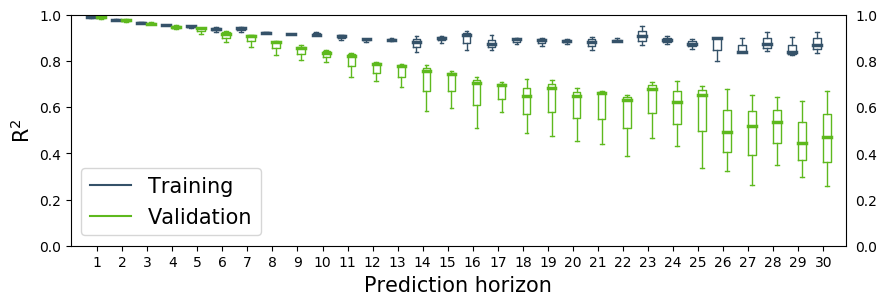

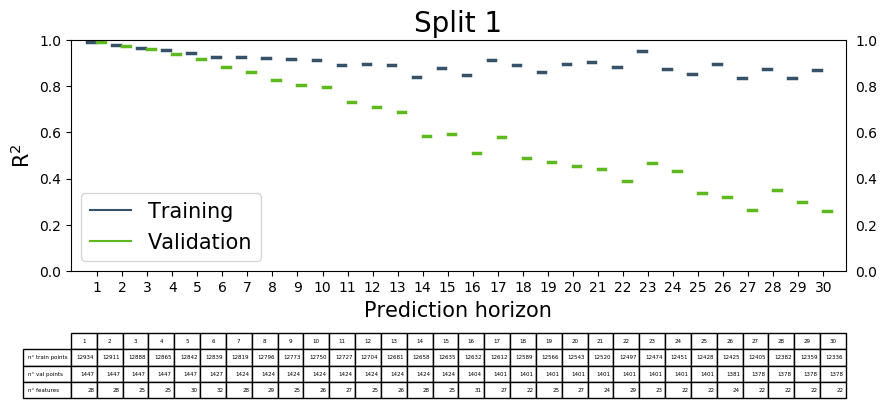

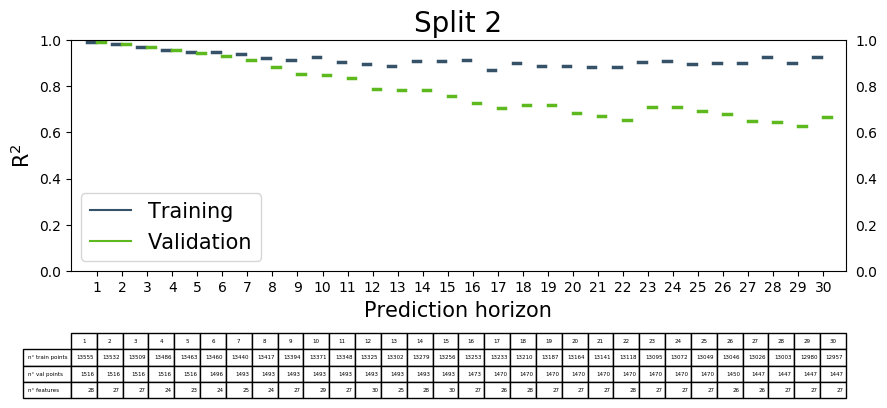

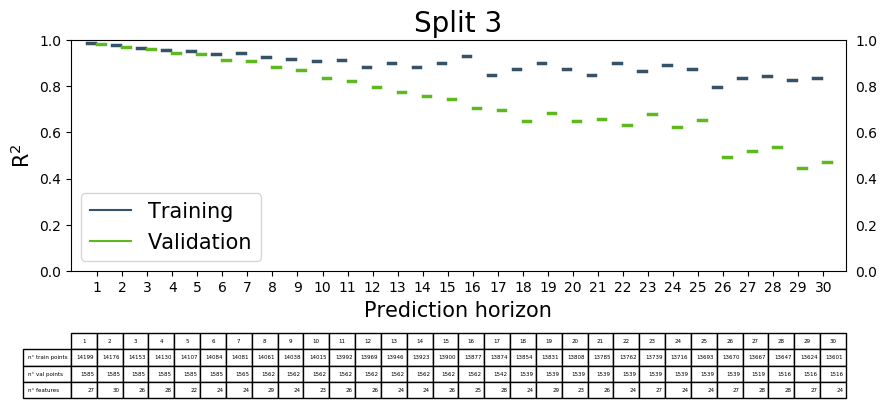

In [20]:
# Create box-plot figure regarding the hyperparameter tuning procedure.
# Create folder where to save results of the hyperparameter tuning.
dir_results_hyperparameter_tuning = dir_output_test + "/hyperparameter_tuning"

if os.path.exists(dir_results_hyperparameter_tuning):
    shutil.rmtree(dir_results_hyperparameter_tuning)
    os.makedirs(dir_results_hyperparameter_tuning)
else:
    os.makedirs(dir_results_hyperparameter_tuning)

with plt.style.context("default"):
    # Get the information of the r2 train for each prediction horizon considering the split information together.
    data_train = best_result[["r2_train"]].unstack().transpose()
    # Get the information of the r2 validation for each prediction horizon considering the split information together.
    data_validation = best_result[["r2_val"]].unstack().transpose()

    # Plot the box-plot.
    fig, axs = plt.subplots(figsize = (10, 3))
    plot_r2_box_plot(data_train.values.T, data_validation.values.T, axs, label_train = "Training", label_test = "Validation", 
                     color_train = "#355269", color_test = "#5eb91e")
    fig.savefig(dir_results_hyperparameter_tuning + "/all_splits.png", bbox_inches = "tight", dpi = 300)

    for i,split_number in enumerate(best_result.index.get_level_values(0).unique()):
        # Create dataframe/table with information about the train and validation shapes.
        table_train = best_result.loc[split_number][["shape_train", "shape_val"]].applymap(lambda x: ast.literal_eval(x))
        table_train["shape"] = table_train.apply(lambda x: (x.shape_train[0], x.shape_val[0], x.shape_train[1]), axis = 1)
        table_train = table_train["shape"].to_dict()
        table_train = pd.DataFrame(table_train, index = ["n° train points", "n° val points", "n° features"])
        # Plot the box-plot.
        fig, axs = plt.subplots(figsize = (10, 3))
        plot_r2_box_plot(data_train[[split_number]].values.T, data_validation[[split_number]].values.T, axs, 
                         label_train = "Training", label_test = "Validation", title = "Split %d" % split_number, 
                         table_train = table_train, color_train = "#355269", color_test = "#5eb91e")
        fig.savefig(dir_results_hyperparameter_tuning + "/split_%d.png" % split_number, bbox_inches = "tight", dpi = 300)

In [21]:
def recursive_improvement(x):
    # Define into a list all the recursive values of the 'loss_to_minimize' metric.
    x = x.to_list()
    # Define a list where to store the improvements of the hyperparameter tuning in time.
    list_improvements = list()
    for i,value in enumerate(x):
        if i == 0:
            best_min = value
        else:
            if best_min > value:
                # Check the improvement from the previous best 'loss_to_minimize' metric.
                diff = best_min - value
                best_min = value
                list_improvements.append(diff)
            else:
                # If no improvement is checked.
                list_improvements.append(0)
            
    return list_improvements

In [22]:
# Compute recursive improvements of the hyperparameter tuning.
hyper_params_recursive = hyper_params.set_index(["split", "h"])["loss_to_minimize"].groupby(axis = 0, level = [0, 1]).apply(recursive_improvement)

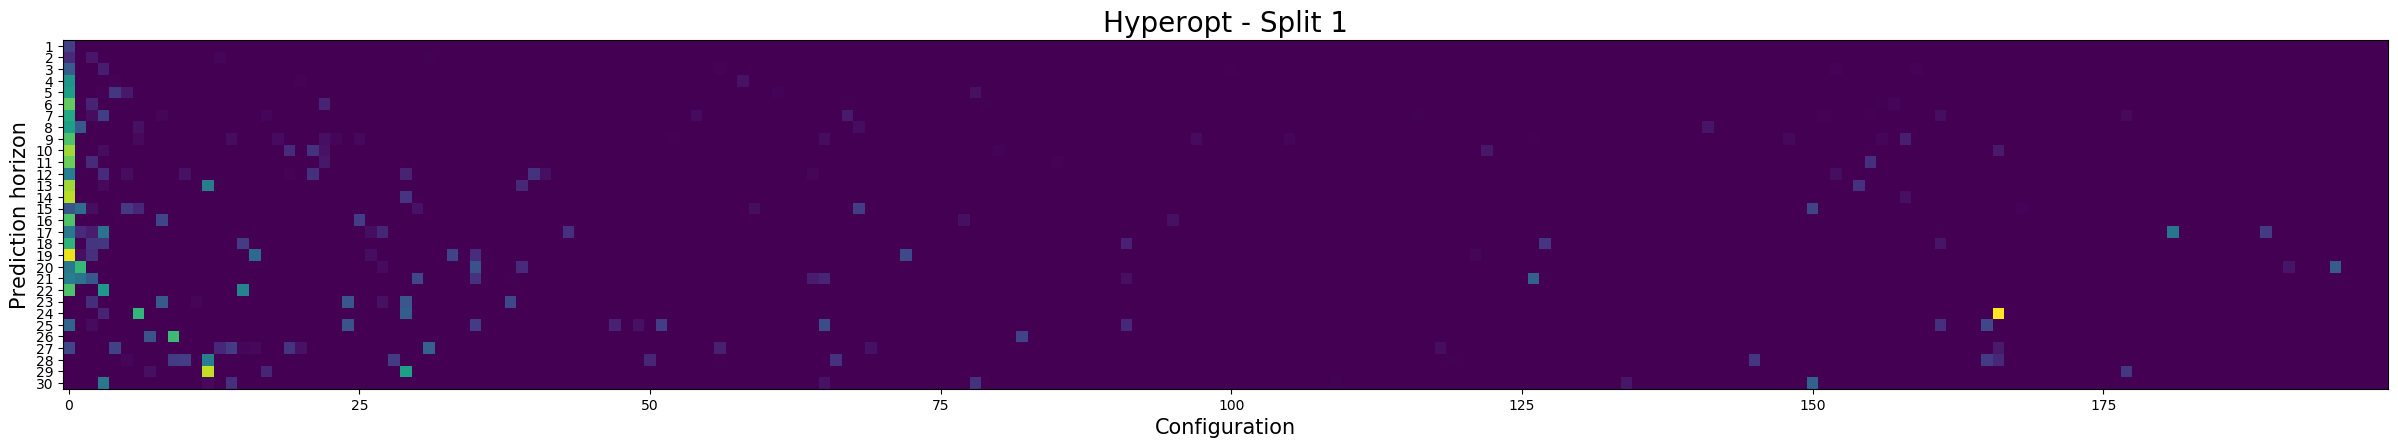

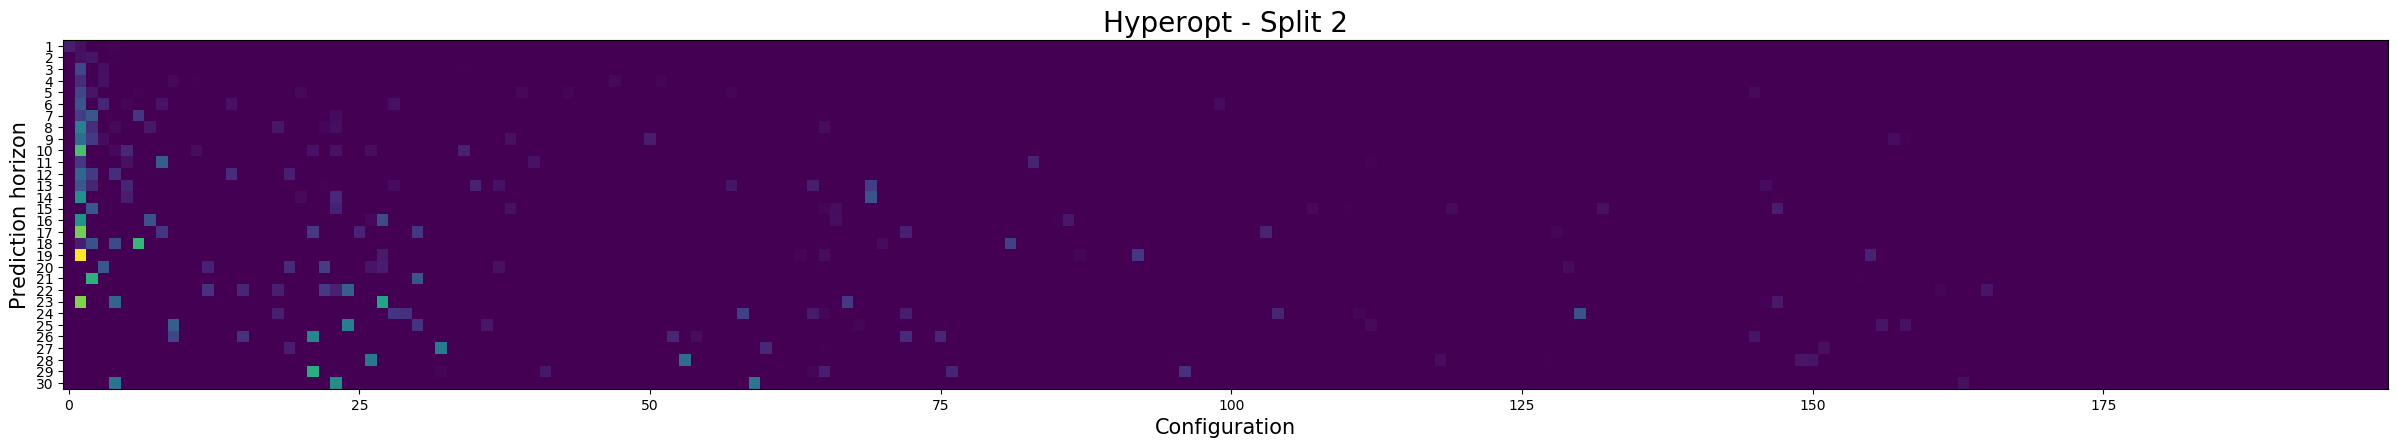

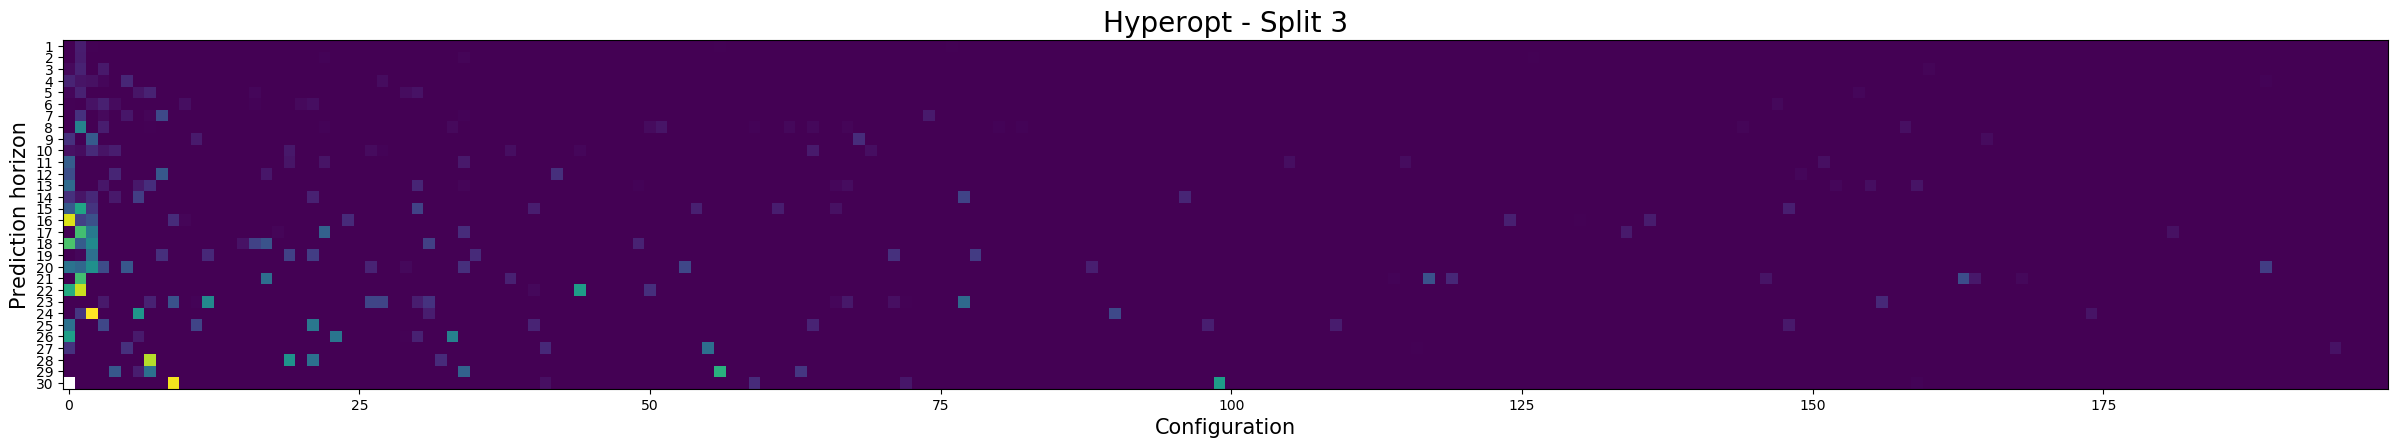

In [23]:
# Plot the figures that descibe the recurive improvements of the hyperparameter tuning.
for split_number in hyper_params_recursive.index.get_level_values(0).unique():
    hyper_params_recursive_1 = hyper_params_recursive.loc[split_number]
    hyper_params_recursive_1 = pd.DataFrame(hyper_params_recursive_1.tolist())
    hyper_params_recursive_1 = hyper_params_recursive_1.iloc[:,:200]
    
    with plt.style.context("default"):
        fig, ax = plt.subplots(figsize = (30, 18))
        im = ax.imshow(hyper_params_recursive_1.astype(float), cmap = "viridis")

        ax.set_yticks(hyper_params_recursive_1.index)
        ax.grid(False)
        ax.set_yticklabels(hyper_params_recursive_1.index + 1)
        ax.set_xlabel("Configuration", fontsize = 15)
        ax.set_ylabel("Prediction horizon", fontsize = 15)
        ax.set_title("Hyperopt - Split %d" % split_number, fontsize = 20)
        for i in range(hyper_params_recursive_1.shape[0]):
            ax.axhline(i + 0.5, color = "white", lw = 0.0)
        
        # Save the figure.
        fig.savefig(dir_results_hyperparameter_tuning + "/recursive_split_%s.png" % split_number, bbox_inches = "tight", dpi = 300)

## Forecasting

In [24]:
SMOOTH_PREDICTION = True

In [25]:
# Open the names of the parameters of the model.
with open(dir_hyper_params + "space1", "rb") as fp:
    parameter_names_model = pickle.load(fp)

In [26]:
# Open the names of the parameters of the indicators.
with open(dir_hyper_params + "space2", "rb") as fp:
    parameter_names_indicator = pickle.load(fp)

In [27]:
# Load the lags dictionary.
with open (dir_hyper_params + "lags_dict", "rb") as fp:
    lags_dict = pickle.load(fp)

In [28]:
# Define the splits to consider to compute the corresponding prediction based on hyperparameters tuning.
SPLITS_TO_USE = best_result.index.get_level_values(0).unique()

In [29]:
def model(train, test, lags_dict, out, target, quantiles = False, hyper = False):
    """
    This function allows to predict 'out' steps ahead in the future of the 'target' variable of each site in the
    'train' group. The predictions of 'out' steps in the future start from the last date of the 'train' group 
    provided.
    
    """
    # Use the best parameters obtained through a previous hyperparameter tuning.
    if hyper:
        # Define the best parameters for the current split obtained by the hyperparameter tuning.
        parameter_names = parameter_names_model + parameter_names_indicator
        best_parameters = best_result.loc[split_number][parameter_names].astype(float)
        # Model parameters.
        best_parameter_indicator = best_parameters[parameter_names_indicator]
        # Indicators parameters.
        best_parameter_model = best_parameters[parameter_names_model]

    #####################
    ### DATA CREATION ###
    #####################
    
    print("Load data...")

    # Define the first level of multi-sites (countries level).
    countries = train.columns.get_level_values(0).unique()

    # Creation of an unique pot for putting the training points (X, y) for all the multi-sites (countries and provinces) for each prediction horizon.
    training_points = {"X": {h+1: [] for h in range(out)}, 
                       "y": {h+1: [] for h in range(out)}}
    # Creation of the input test points specifically for each site (country and province) and prediction horizon.
    test_input_points = {country: {province: {h+1: None for h in range(out)} for province in train[country].columns.get_level_values(0).unique()} for country in countries}

    for country in countries:
        # Select the subdataframe corresponding to the current country.
        train_country = train[country]
        # Define the second level of multi-sites (provinces level).
        provinces = train_country.columns.get_level_values(0).unique()
        for province in provinces:
            for h in range(out):
                # Training samples.
                X_train = pd.read_csv(dir_data + "/train/%s/%s/X_train_split%d_h%d.csv" % (country, province, split_number, h+1), header = [0, 1], index_col = 0) 
                y_train = pd.read_csv(dir_data + "/train/%s/%s/y_train_split%d_h%d.csv" % (country, province, split_number, h+1), header = [0, 1], index_col = 0) 
                X_test = pd.read_csv(dir_data + "/test/%s/%s/X_test_split%d_h%d.csv" % (country, province, split_number, h+1), header = [0, 1], index_col = 0) 

                # Get the features to keep for the current prediction horizon according to the hyperparameter tuning.
                if hyper:
                    # Select features.
                    # Decide the indicators to keep based on values (0 or 1).
                    space_features = {k: v for k,v in dict(best_parameter_indicator.loc[h+1]).items() if v == 1}
                    # Select the corresponding lags.
                    space_features = {feature: lags_dict[feature] for feature in space_features.keys()}
                    # Flatten list.
                    features = list(itertools.chain(*list(space_features.values())))
                    # Keep features.
                    X_train = pd.concat([X_train.loc[:, feature] for feature in features], axis = 1).sort_index(axis = 1)
                    X_test = pd.concat([X_test.loc[:, feature] for feature in features], axis = 1).sort_index(axis = 1)

                # Store information.
                training_points["X"][h+1].append(X_train)
                training_points["y"][h+1].append(y_train)
                test_input_points[country][province][h+1] = X_test

    # Concatenate training data for each prediction horizon in order to consider them into an unique pot.
    for h in range(out):
        training_points["X"][h+1] = pd.concat(training_points["X"][h+1]).reset_index(drop = True) 
        training_points["y"][h+1] = pd.concat(training_points["y"][h+1]).reset_index(drop = True) 
        
    print("Complete!")
        
    ###################
    ### FORECASTING ###
    ###################
    
    print("Forecasting...")

    # Create the dataframe where to store the predictions of the target.
    c1 = pd.MultiIndex.from_tuples(map(lambda x: (x[0], x[1], "lower_quantile"), train.columns.droplevel(2)), names = ["Country", "AdminStrata", "Target"])
    c2 = pd.MultiIndex.from_tuples(map(lambda x: (x[0], x[1], "Forecast"), train.columns.droplevel(2)), names = ["Country", "AdminStrata", "Target"])
    c3 = pd.MultiIndex.from_tuples(map(lambda x: (x[0], x[1], "upper_quantile"), train.columns.droplevel(2)), names = ["Country", "AdminStrata", "Target"])
    predictions = pd.DataFrame(index = test.index, columns = c1.union(c2).union(c3))   

    # Training model.
    models = {h+1: None for h in range(out)}
    r2_train = {h+1: None for h in range(out)}
    r2_test = {country: {h+1: None for h in range(out)} for country in countries}
    for h in range(out):
        # Train the model for the current prediction horizon.
        X_train, y_train = training_points["X"][h+1], training_points["y"][h+1]
        
        # Get the best model parameters for the current prediction horizon if exist the information about.
        if hyper:
            # Select best model parameters.
            best_parameter_model_h = dict(best_parameter_model.loc[h+1])
            # Convert to int type the float numbers that are integers.
            best_parameter_model_h = {k: int(v) if v.is_integer() else v for k,v in best_parameter_model_h.items()}

        # Model.
        if quantiles:
            model = None
            # Lower model.
            model_lower = None
            # Upper model.
            model_upper = None
        else:  
            if hyper:
                model = xgb.XGBRegressor(**best_parameter_model_h, objective = "reg:squarederror")
            else:
                model = xgb.XGBRegressor(n_estimators = 100, objective = "reg:squarederror")
            # Train model.
            model.fit(X_train, y_train)
            # Lower model.
            model_lower = None
            # Upper model.
            model_upper = None
        
        # Save models.
        models[h+1] = (model, model_lower, model_upper, X_train.columns)
        # Save training r2 scores.
        r2_train[h+1] = model.score(X_train, y_train)
       
        # Forecasting.
        for country in countries:
            X_test_list, y_test_list = list(), list()
            # Define the second level multi-sites (provinces).
            provinces = train[country].columns.get_level_values(0).unique()
            for province in provinces:
                X_test = test_input_points[country][province][h+1]
                y_hats = model.predict(X_test)[0]
                
                # Save the true information about this test point.
                X_test_list.append(X_test)
                y_true = test[(country, province, target)].loc[predictions.index[h]] 
                y_test_list.append([y_true])

                # Store the predicted values into the dataframe.
                predictions[(country, province, "Forecast")].loc[predictions.index[h]] = y_hats

                # Prediction for the quantiles.
                if quantiles:
                    y_hats_lower = model_lower.predict(X_test)[0]
                    predictions[(country, province, "lower_quantile")].loc[predictions.index[h]] = y_hats_lower
                    y_hats_upper = model_upper.predict(X_test)[0]
                    predictions[(country, province, "upper_quantile")].loc[predictions.index[h]] = y_hats_upper

            # Compute the r2 test for the current prediction horizon and country.
            r2_test_country = model.score(pd.concat(X_test_list).reset_index(drop = True), np.expand_dims(np.concatenate(y_test_list), 1))
            r2_test[country][h+1] = r2_test_country  
 
    # Define the shape of the training and test points.    
    shape_training_points = training_points.copy()
    shape_test_points = test_input_points.copy()
    for h in range(out):
        shape_training_points["X"][h+1] = shape_training_points["X"][h+1].shape
        shape_training_points["y"][h+1] = shape_training_points["y"][h+1].shape
        for country in countries:
            provinces = train[country].columns.get_level_values(0).unique()
            for province in provinces:
                shape_test_points[country][province][h+1] = shape_test_points[country][province][h+1].shape
                
    print("Complete!")

    return predictions, models, r2_train, r2_test, shape_training_points, shape_test_points

In [30]:
# Create a dictionary to store forecasting information for each split.
information_to_store = {"shape_train": None, # Save the shape of the training points.
                        "shape_test": None, # Save the shape of the test points.
                        "r2_train": None, # Save the r2 on the training points.
                        "r2_test": None, # Save the r2 on the test points.
                        "models": None, # Save the trained models (one for each prediction horizon) with the corresponding feature names.
                        "prediction_sites": None, # Save the predictions for each site (province).
                        "loss_sites": None, # Save the prediction loss (mse) for each site (province).
                        "loss_overall": None, # Save the overall loss. 
                        "loss_h": None} # Save the loss as function of the prediction horizon among all the sites (province).

TOTAL_RESULTS = {split_number: information_to_store.copy() for split_number in SPLITS_TO_USE}

# Forecasting.
for split_number, (train, test) in SPLITS.items():
    if split_number in SPLITS_TO_USE:
        print("SPLIT %d/%d" % (split_number, len(SPLITS.keys())))

        ## ACTUAL ##
        # Define the test points of the target to predict for each site (country and province).
        true = test.xs(TARGET, axis = 1, level = 2, drop_level = False)
        # Define the number of days to predict.
        test_size = len(true)
        print("Range of days to predict: %s - %s" % (str(true.index[0].date()), str(true.index[-1].date())))

        ## NAIVE ##
        # Define the predictions for the Naive model.
        naive = train.xs(TARGET, axis = 1, level = 2, drop_level = False).iloc[-1].to_frame().transpose()
        naive = naive.loc[naive.index.repeat(test_size)]
        naive = naive.rename(columns = {"FCG": "Naive"})
        naive.index = true.index

        ## MODEL ##
        # Train the model to predict the test_size points for each site (country and province).
        predictions, models, r2_train, r2_test, shape_train, shape_test = model(train, test, lags_dict, TEST_SIZE, TARGET, 
                                                                                quantiles = False, hyper = True)

        # Smooth the output prediction over the prediction horizons.
        if SMOOTH_PREDICTION:
            def smooth_output(serie):
                if serie.isna().sum() > 0:
                    return serie
                else:
                    # Smooth serie.
                    smooth_serie = savgol_filter(serie, 15, 3)
                    return smooth_serie
            predictions = predictions.apply(smooth_output)

        ## ALL ##
        results = pd.concat([true, predictions, naive], axis = 1).sort_index(axis = 1, level = 0)
        
        # Analysis of the forecast results.  
        # Define the total prediction loss for each site (province) not considering quantiles.
        select = results.columns.get_level_values(2).isin(["Forecast", TARGET, "Naive"])
        results_no_quantiles = results.loc[:, select]

        def f_loss(x, level):
            # Model.
            model = mse(x.xs(TARGET, axis = 1, level = level), x.xs("Forecast", axis = 1, level = level))
            # Naive.
            naive = mse(x.xs(TARGET, axis = 1, level = level), x.xs("Naive", axis = 1, level = level))  
            return pd.Series([model, naive], index = ["Model", "Naive"])

        loss_sites = results_no_quantiles.groupby(axis = 1, level = [0, 1]).apply(lambda x: f_loss(x, 2)).transpose()

        # Define the overall loss.
        loss = loss_sites.groupby(axis = 0, level = 0).mean().mean()
        print("Overall loss:")
        print(loss)
        print("Country loss:")
        print(loss_sites.groupby(axis = 0, level = 0).mean())

        # Compute the loss as a function of the prediction horizon among all the sites (provinces).
        loss_h = results_no_quantiles.transpose().unstack(2).groupby(axis = 0, level = 0).apply(lambda x: x.groupby(axis = 1, level = 0).apply(lambda x: f_loss(x, 1)).transpose())

        # Save the results for the current split.
        TOTAL_RESULTS[split_number]["r2_train"] = r2_train 
        TOTAL_RESULTS[split_number]["r2_test"] = r2_test  
        TOTAL_RESULTS[split_number]["shape_train"] = shape_train 
        TOTAL_RESULTS[split_number]["shape_test"] = shape_test 
        TOTAL_RESULTS[split_number]["models"] = models 
        TOTAL_RESULTS[split_number]["prediction_sites"] = results
        TOTAL_RESULTS[split_number]["loss_sites"] = loss_sites
        TOTAL_RESULTS[split_number]["loss_overall"] = loss
        TOTAL_RESULTS[split_number]["loss_h"] = loss_h

SPLIT 1/3
Range of days to predict: 2020-06-01 - 2020-06-30
Load data...
Complete!
Forecasting...
Complete!
Overall loss:
Model    115.511704
Naive    105.959239
dtype: float64
Country loss:
              Model       Naive
Country                        
Nigeria  193.458822  177.685776
Yemen     37.564587   34.232702
SPLIT 2/3
Range of days to predict: 2020-07-01 - 2020-07-30
Load data...
Complete!
Forecasting...
Complete!
Overall loss:
Model    43.191536
Naive    15.052954
dtype: float64
Country loss:
             Model      Naive
Country                      
Nigeria  75.562395  11.746100
Yemen    10.820676  18.359809
SPLIT 3/3
Range of days to predict: 2020-08-01 - 2020-08-30
Load data...
Complete!
Forecasting...
Complete!
Overall loss:
Model    102.566871
Naive     67.807469
dtype: float64
Country loss:
              Model       Naive
Country                        
Nigeria  192.195165  121.720226
Yemen     12.938576   13.894712


## Results analysis

### Overall result

In [31]:
total_loss = list()
for split_number in SPLITS_TO_USE:
    loss = TOTAL_RESULTS[split_number]["loss_overall"]
    total_loss.append(loss)

In [32]:
print("Overall loss (mse):")
pd.concat(total_loss, axis = 1).mean(axis = 1)

Overall loss (mse):


Model    87.090037
Naive    62.939887
dtype: float64

In [33]:
total_loss_country = list()
for split_number in SPLITS_TO_USE:
    loss = TOTAL_RESULTS[split_number]["loss_sites"].groupby(axis = 0, level = 0).mean()
    total_loss_country.append(loss)

In [34]:
print("Overall loss (mse):")
pd.concat(total_loss_country, axis = 1).groupby(axis = 1, level = 0).mean()

Overall loss (mse):


Model       Naive
Country                        
Nigeria  153.738794  103.717367
Yemen     20.441280   22.162408

### Total prediction loss for the sites among the various splits

In [35]:
def full_extent(ax, pad = 0.0):
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    return bbox.expanded(1.0 + pad, 1.0 + pad)

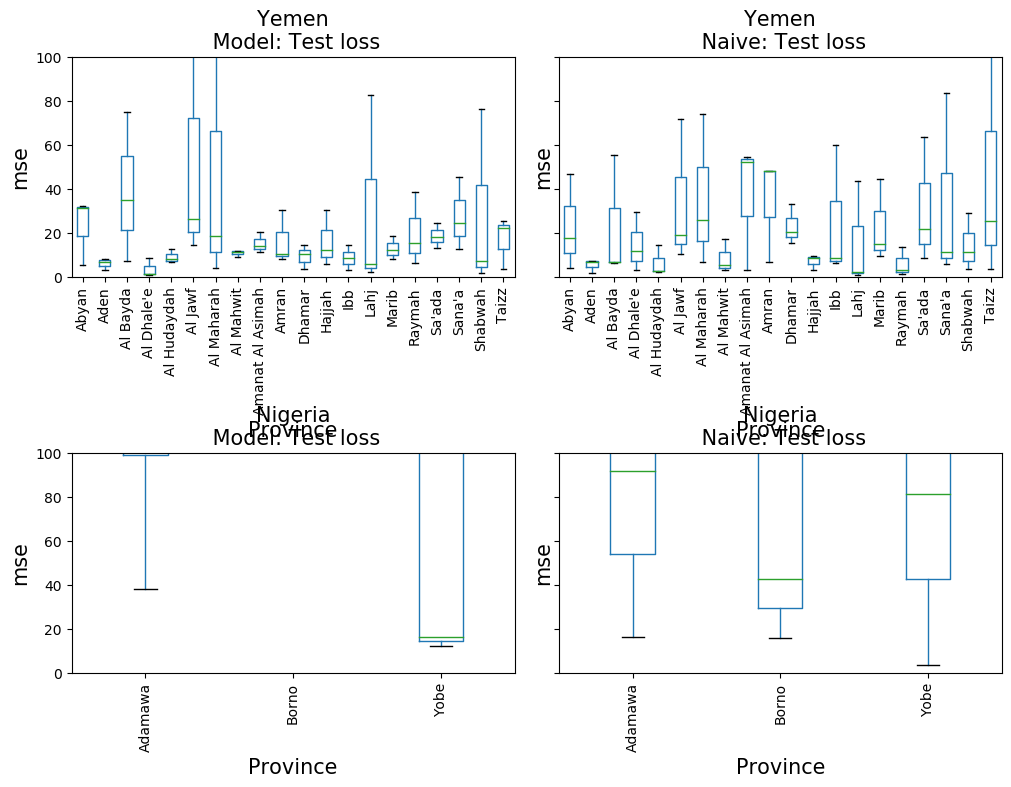

In [36]:
with plt.style.context("default"):
    # Define the number of figures on x axis.
    cols = 2
    # Define the number of figures on y axis.
    rows = len(COUNTRIES_TO_CONSIDER)
    # Define the subplot figure.
    fig, axs = plt.subplots(len(COUNTRIES_TO_CONSIDER),2, sharey = True, figsize = (6*cols, 4*rows), squeeze = False)
    fig.subplots_adjust(wspace = 0.1, hspace = 0.8)
    for j,country in enumerate(COUNTRIES_TO_CONSIDER):
        value = pd.DataFrame()
        for split_number in SPLITS_TO_USE:
            loss_sites = TOTAL_RESULTS[split_number]["loss_sites"].loc[country]
            value = pd.concat([value, loss_sites], axis = 1, sort = True)
        for i,m in enumerate(value.columns.get_level_values(0).unique()):
            # Create box-plot.
            value[[m]].transpose().reset_index(drop = True).boxplot(rot = 90, ax = axs[j,i])
            # Set attributes box-plot.
            axs[j,i].set_title(country + "\n %s: Test loss" % m, fontsize = 15)
            axs[j,i].set_xlabel("Province", fontsize = 15)
            axs[j,i].set_ylabel("mse", fontsize = 15)
            axs[j,i].set_ylim([0, 100])
            axs[j,i].grid(b = None)
            
            # Save just the portion of the current axes.
            extent = full_extent(axs[j,i]).transformed(fig.dpi_scale_trans.inverted())
            extent = axs[j,i].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(dir_output_test + "/Sites_%s_%s.png" % (country, m), bbox_inches = extent, dpi = 300)

### Loss of each split as function of the prediction horizon

In [37]:
colors = {"Naive": "red", "Model": "blue"}

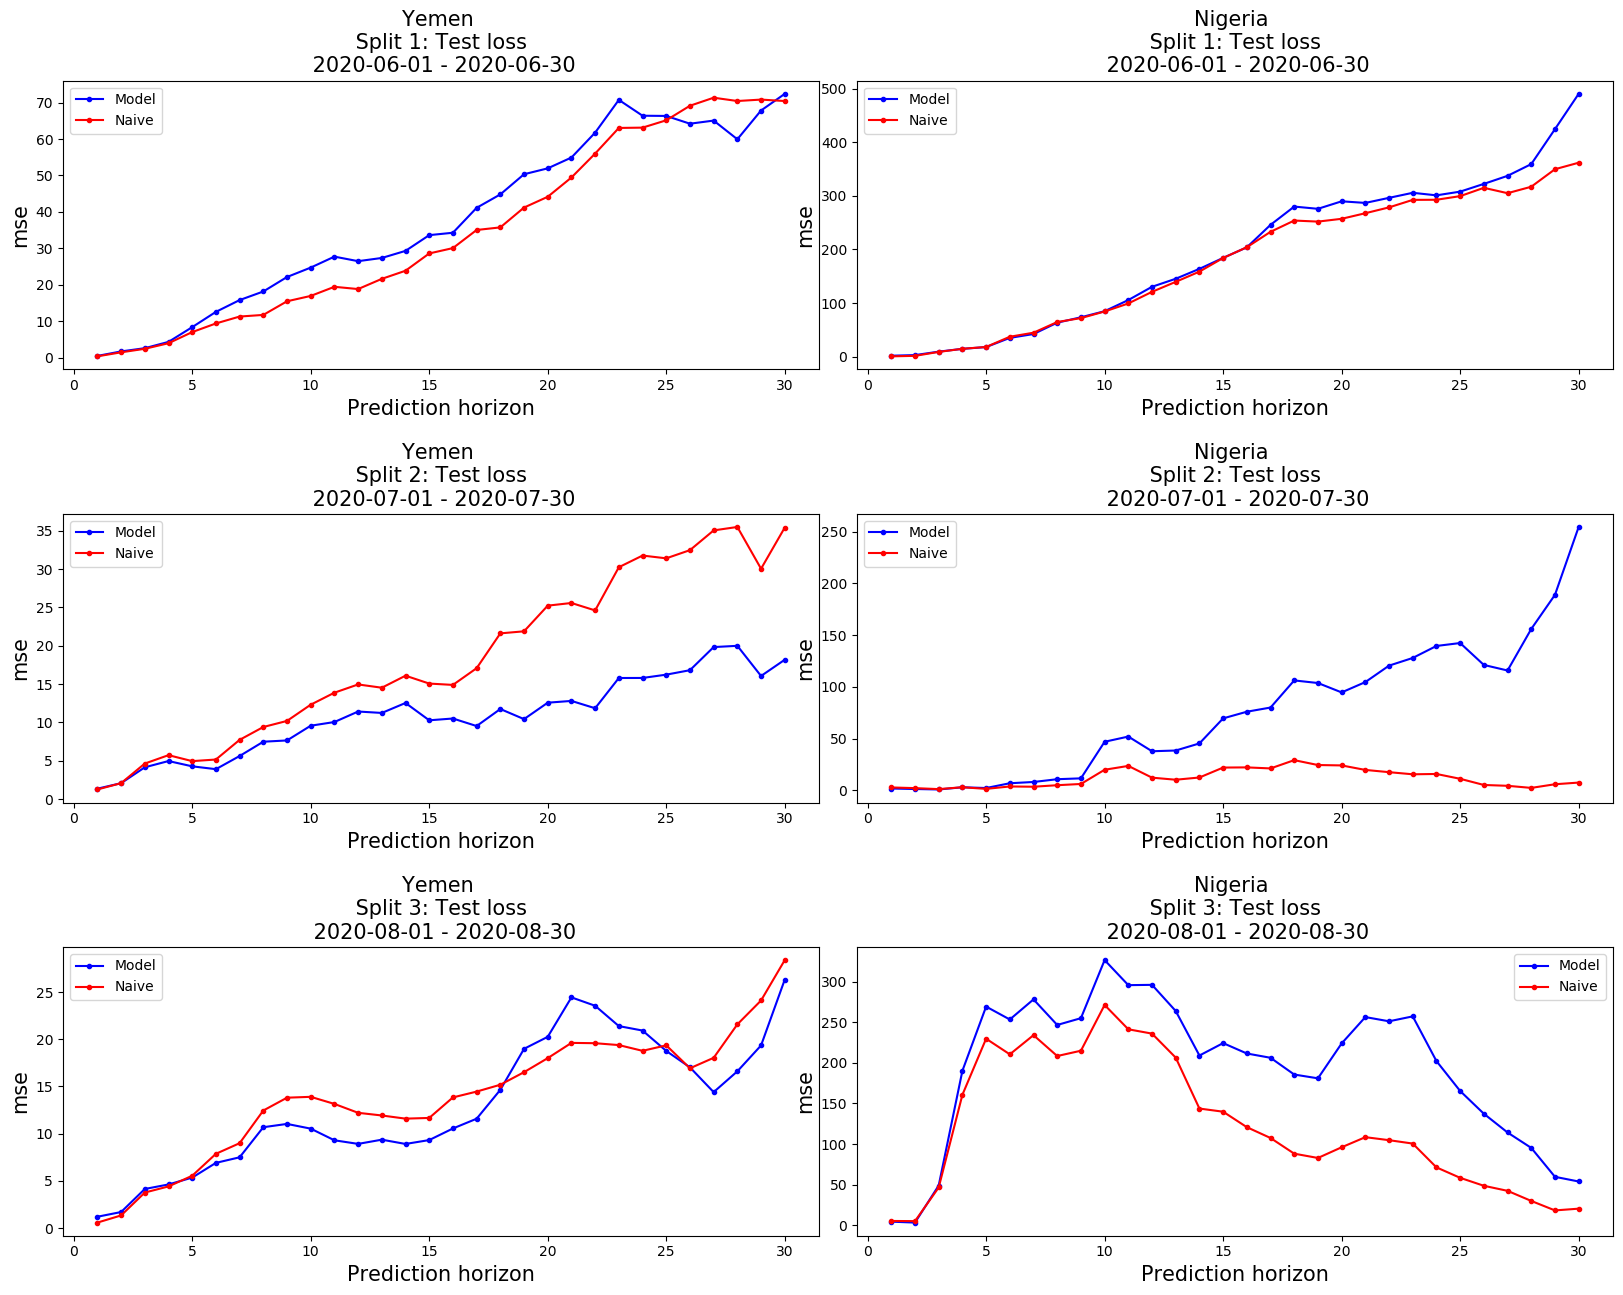

In [38]:
with plt.style.context("default"):
    # Define the number of figures on x axis.
    cols = len(COUNTRIES_TO_CONSIDER)
    # Define the number of figures on y axis.
    rows = len(SPLITS_TO_USE)
    # Define the subplot figure.
    fig, axs = plt.subplots(rows, cols, figsize = (10*cols, 5*rows), squeeze = False)
    fig.subplots_adjust(wspace = 0.05, hspace = 0.5)
    for j,country in enumerate(COUNTRIES_TO_CONSIDER):
        value = pd.DataFrame()
        for i,split_number in enumerate(SPLITS_TO_USE):      
            loss_sites = TOTAL_RESULTS[split_number]["loss_h"].loc[country].reset_index(drop = True)
            for k,m in enumerate(loss_sites.columns.get_level_values(0).unique()):  
                value_statistic = loss_sites[[m]]
                value_statistic.index = loss_sites.index + 1
                
                # Get the start and the end dates of the test set of the current split.
                start, end = str(SPLITS[split_number][1].index[0].date()), str(SPLITS[split_number][1].index[-1].date())
                
                # Plot.
                value_statistic[m].plot(style = ".-", label = m, ax = axs[i,j], c = colors[m])
                # Set attributes of the plot.
                axs[i,j].set_title("%s \n Split %d: Test loss \n %s - %s" % (country, split_number, start, end), fontsize = 15)
                axs[i,j].legend(loc = "best")
                axs[i,j].set_xlabel("Prediction horizon", fontsize = 15)
                axs[i,j].set_ylabel("mse", fontsize = 15)
                
                # Save just the portion of the current axes.
                extent = full_extent(axs[i,j]).transformed(fig.dpi_scale_trans.inverted())
                extent = axs[i,j].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
                fig.savefig(dir_output_test + "/Loss_split_%d_%s.png" % (split_number, country), bbox_inches = extent, dpi = 300)

### Total loss over the splits as function of the prediction horizon

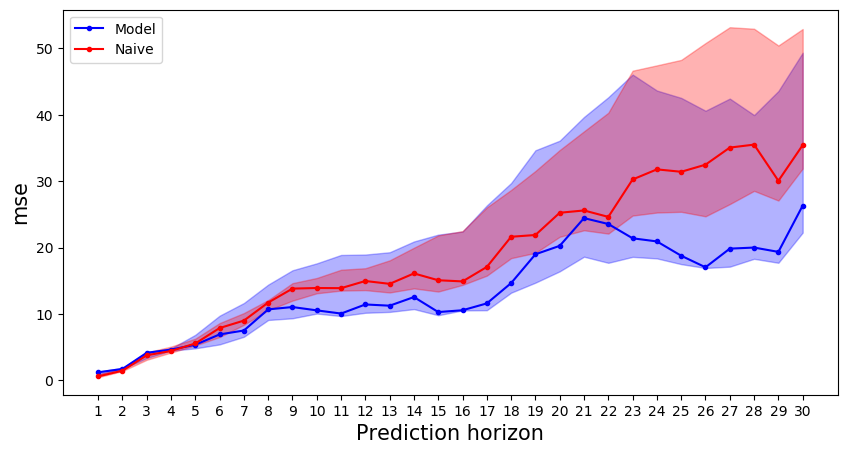

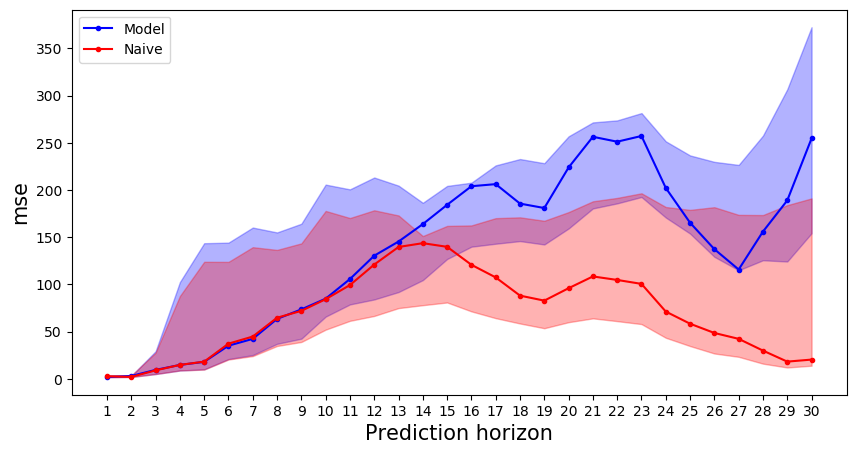

In [39]:
with plt.style.context("default"):
    for j,country in enumerate(COUNTRIES_TO_CONSIDER):
        fig, axs = plt.subplots(figsize = (10, 5))
        value = pd.DataFrame()
        for split_number in SPLITS_TO_USE:      
            loss_sites = TOTAL_RESULTS[split_number]["loss_h"].loc[country].reset_index(drop = True)
            value = pd.concat([value, loss_sites], axis = 1, sort = True)           
        for i, m in enumerate(value.columns.get_level_values(0).unique()):    
            value_statistic = value[[m]].agg([lambda x: x.quantile(0.25), np.median, lambda x: x.quantile(0.75)], axis = 1)
            value_statistic.columns = ["lower_quantile", "median", "upper_quantile"]
            value_statistic.index = value_statistic.index + 1

            # Plot.
            value_statistic["median"].plot(style = ".-", label = m, ax = axs, c = colors[m])
            axs.fill_between(x = value_statistic["median"].index, y1 = value_statistic["lower_quantile"], 
                             y2 = value_statistic["upper_quantile"], color = colors[m], alpha = 0.3)
            # Set attributes of the plot.
            #axs[j,0].set_title("%s \n Test loss" % country, fontsize = 15)
            axs.legend(loc = "upper left")
            axs.set_xlabel("Prediction horizon", fontsize = 15)
            axs.set_ylabel("mse", fontsize = 15)
            axs.set_xticks(np.arange(1, 31))

            fig.savefig(dir_output_test + "/Loss_%s.png" % (country), bbox_inches = "tight", dpi = 300)

### Predictions

In [40]:
def plot_predictions(name1, name2, results):
     # Select the subdataframe.
    if name1 != None and name2 != None:
        group = results[name1]["prediction_sites"][name2]

        def add_entire_target(group):
            province = group.name
            select = group.columns.get_level_values(1).isin(["Forecast", "lower_quantile", "upper_quantile"])
            group = group.loc[:, select]
            actual = df[name2].xs(TARGET, axis = 1, level = 1, drop_level = False)[(province, "FCG")].to_frame()

            return pd.concat([group, actual], axis = 1)

        group = group.groupby(axis = 1, level = 0, group_keys = False).apply(add_entire_target)
        group = group.rename(columns = {"FCG": "original", "Forecast": "forecast"}, level = 1)
        
        # Get the start and the end dates of the test set.
        start, end = str(SPLITS[name1][1].index[0].date()), str(SPLITS[name1][1].index[-1].date())

        with plt.style.context("default"):
            # Plot prediction.
            TsIP(group[:end]).interactive_plot_predictions(quantiles = False, title = "%s - %s" % (start, end), matplotlib = True, 
                                                           yaxis = "% of people with poor and \n borderline food consumption", style = "lines", 
                                                           first_last_valid_index_group = True, save_path = dir_output_test + "/prediction.png")                  
    else:
        pass

# Create figure.
w1 = widgets.Dropdown(options = TOTAL_RESULTS.keys(), description = "Split", disabled = False, value = None)
w2 = widgets.Dropdown(options = COUNTRIES_TO_CONSIDER, description = "Country", disabled = False, value = None)

hbox = widgets.HBox([w1, w2])
out = widgets.interactive_output(plot_predictions, {"name1": w1, "name2": w2, "results": fixed(TOTAL_RESULTS)})
display(hbox, out)     

Output()

### r2 scores

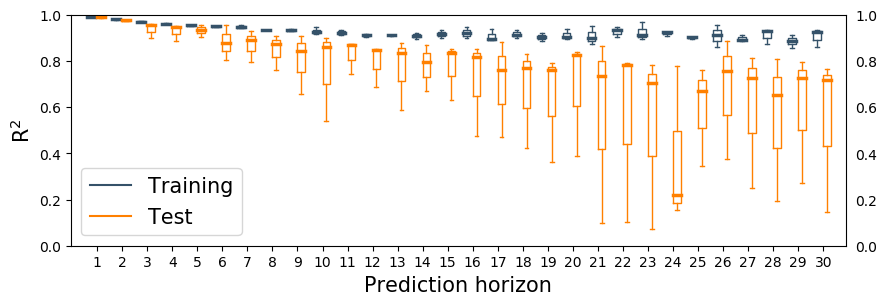

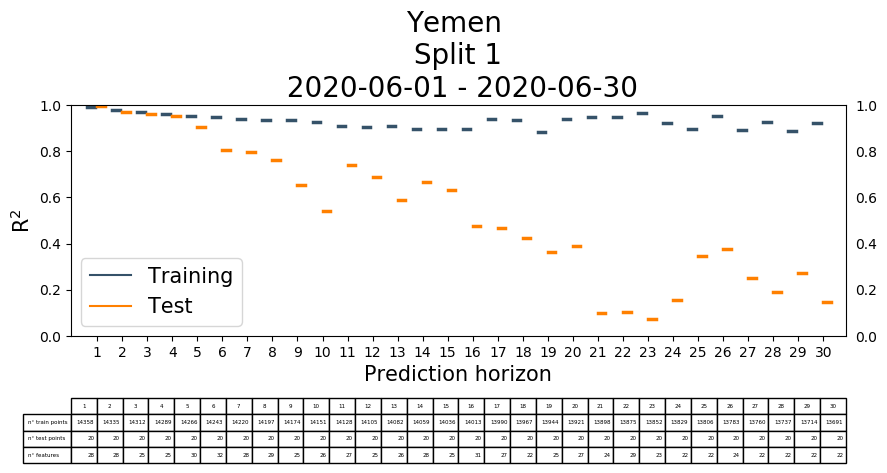

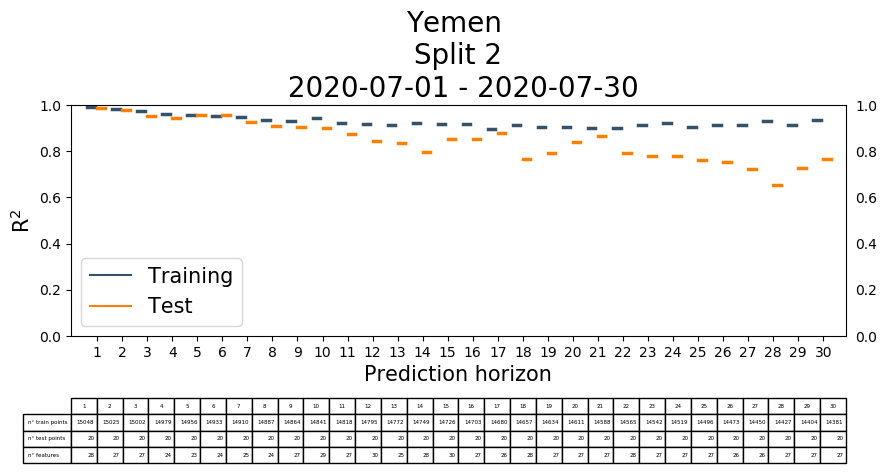

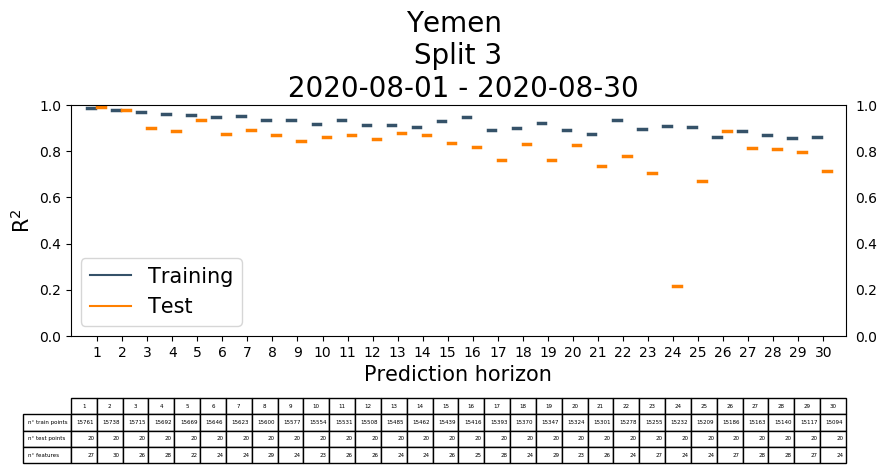

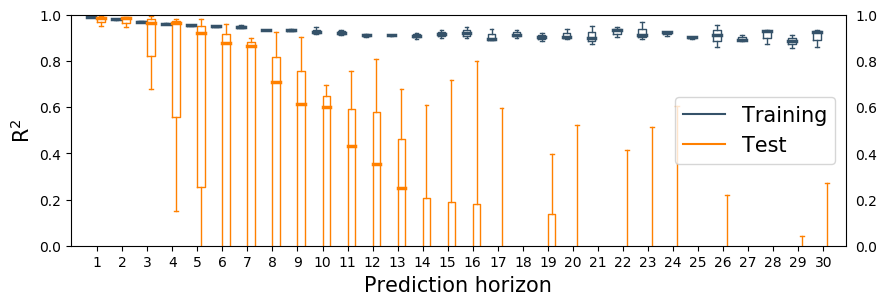

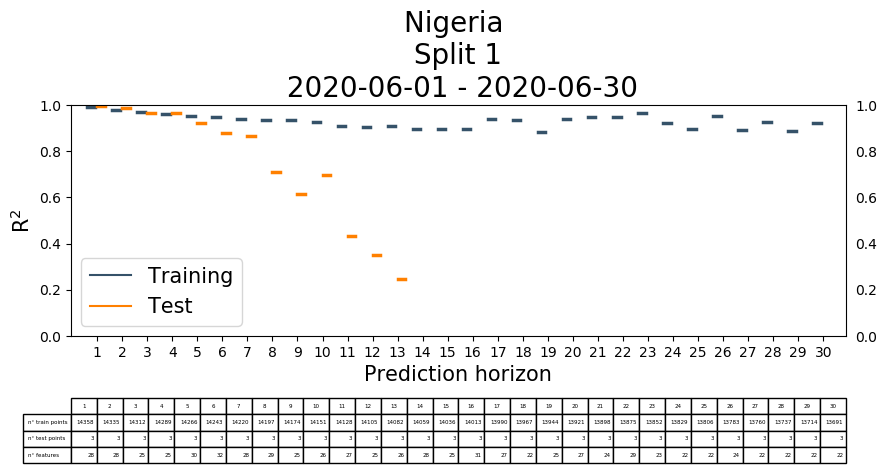

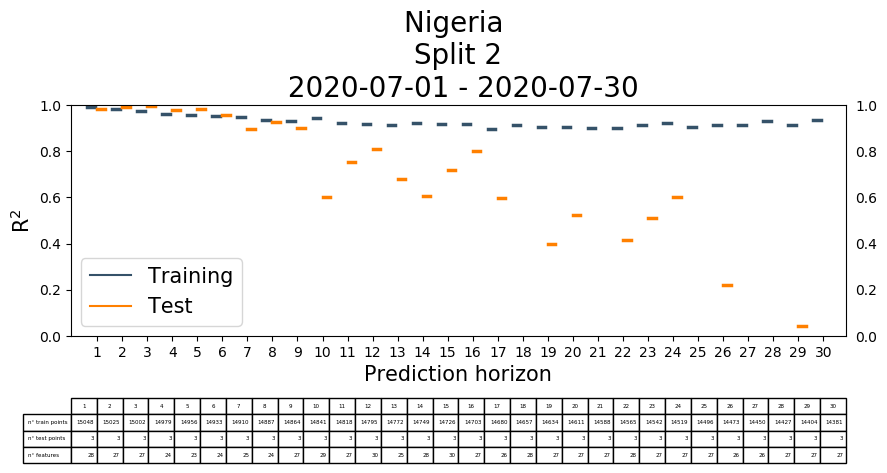

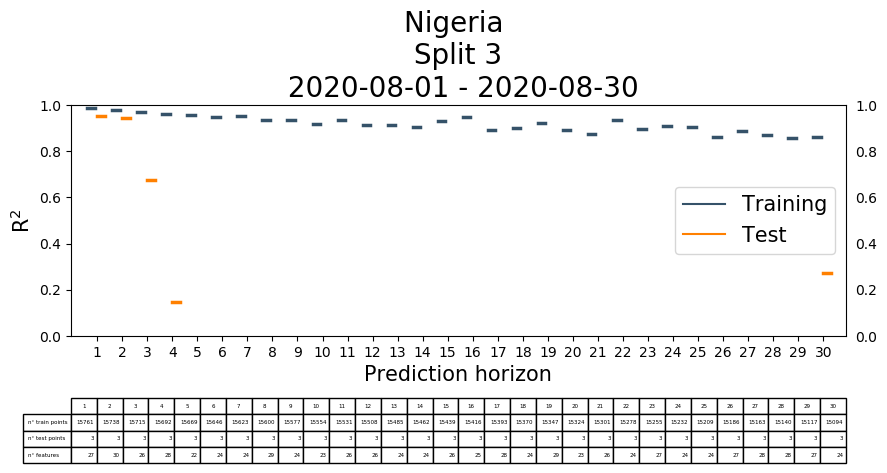

In [41]:
with plt.style.context("default"):
    for j,country in enumerate(COUNTRIES_TO_CONSIDER):
        # Get the information of the r2 train for each prediction horizon considering the split information together.
        data_train = pd.DataFrame({split_number: TOTAL_RESULTS[split_number]["r2_train"].values() for split_number in TOTAL_RESULTS.keys()})
        data_train.index = data_train.index + 1
        # Get the information of the r2 test for each prediction horizon considering the split information together.
        data_test = pd.DataFrame({split_number: TOTAL_RESULTS[split_number]["r2_test"][country].values() for split_number in TOTAL_RESULTS.keys()})
        data_test.index = data_test.index + 1
        
        # Plot the box-plot.
        fig, axs = plt.subplots(figsize = (10, 3))
        plot_r2_box_plot(data_train.values.T, data_test.values.T, axs, label_train = "Training", label_test = "Test", 
                         title = None, color_train = "#355269", color_test = "#ff8000")
        fig.savefig(dir_output_test + "/total_%s.png" % country, bbox_inches = "tight", dpi = 300)

        for i,split_number in enumerate(TOTAL_RESULTS.keys()):
            # Get the start and the end dates of the test set for the current split.
            start, end = str(SPLITS[split_number][1].index[0].date()), str(SPLITS[split_number][1].index[-1].date())
            # Get the information about the shapes of the training and test points.
            # Train.
            shape_train = pd.DataFrame(TOTAL_RESULTS[split_number]["shape_train"]["X"], index = ["n° train points", "n° features"])
            # Test.
            shape_test = pd.DataFrame(TOTAL_RESULTS[split_number]["shape_test"][country])
            shape_test = pd.concat([pd.DataFrame(shape_test[x].values.tolist(), columns = ["n° test points", "n° features"]) for x in shape_test.columns], 
                                   axis = 1, keys = shape_test.columns)
            shape_test.index = shape_test.index + 1
            shape_test = shape_test.groupby(axis = 1, level = 1).sum()
            # Concatenate data.
            shapes = pd.concat([shape_train.loc["n° train points"], shape_test[["n° test points"]], shape_train.loc["n° features"]], axis = 1)
            shapes = shapes.transpose()
            # Plot the box-plot.
            fig, axs = plt.subplots(figsize = (10, 3))
            plot_r2_box_plot(data_train[[split_number]].values.T, data_test[[split_number]].values.T, axs, label_train = "Training", 
                             label_test = "Test", title = "%s \n Split %d \n %s - %s" % (country, split_number, start, end), 
                             table_train = shapes, color_train = "#355269", color_test = "#ff8000")
            fig.savefig(dir_output_test + "/split_%d_%s.png" % (split_number, country), bbox_inches = "tight", dpi = 300)

### Actual vs Forecast

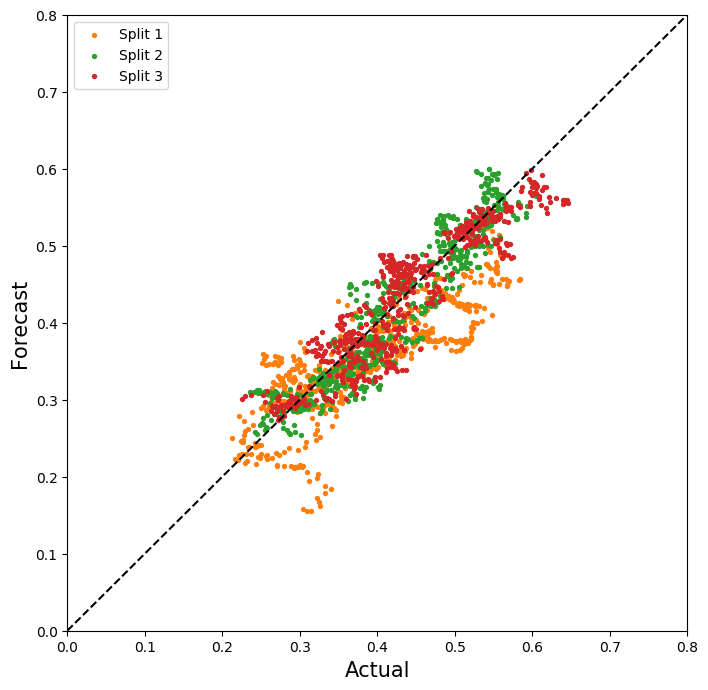

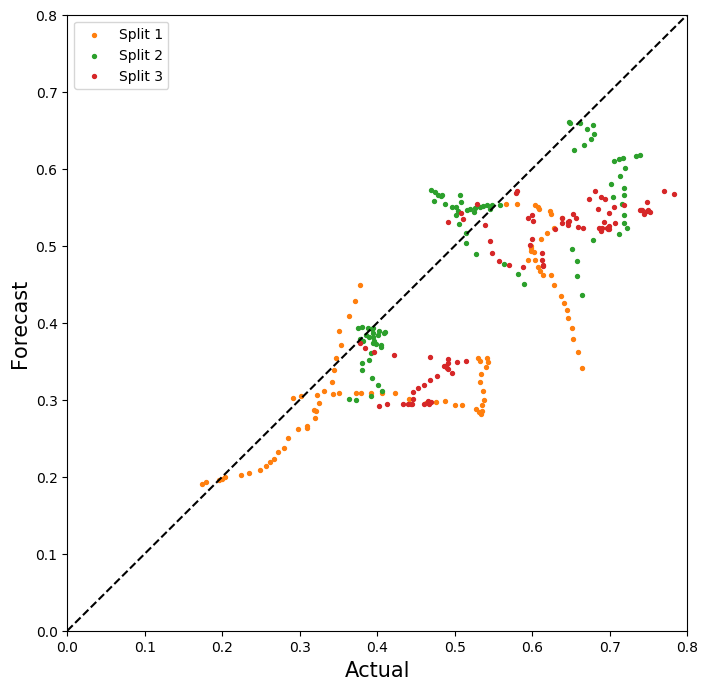

In [42]:
with plt.style.context("default"):
    for country in COUNTRIES_TO_CONSIDER:
        fig, axs = plt.subplots(figsize = (8, 8))
        axs.set_ylim([0, 1])
        axs.set_xlim([0, 1])
        # Add bisector.
        axs.plot(axs.get_xlim(), axs.get_ylim(), color = "black", linestyle = "--")

        for split_number in SPLITS_TO_USE:
            predictions = TOTAL_RESULTS[split_number]["prediction_sites"][[country]].copy()
            predictions = predictions.drop(["Naive", "lower_quantile", "upper_quantile"], axis = 1, level = 2)
            predictions = predictions/100

            def plot_scatter(group):
                gr = group[group.name[0]][group.name[1]]
                start, end = str(gr.index[0].date()), str(gr.index[-1].date())
                #label = start + " - " + end
                label = "Split %d" % (split_number)
                gr.plot.scatter(x = "FCG", y = "Forecast", s = 8, color = plt.get_cmap("tab10")(split_number), ax = axs, label = label)
                # Legend.
                handles, labels = plt.gca().get_legend_handles_labels()
                by_label = dict(zip(labels, handles))
                axs.legend(by_label.values(), by_label.keys(), loc = "best")
                axs.set_xlim(0, 0.8)
                axs.set_ylim(0, 0.8)

            predictions.groupby(axis = 1, level = [0, 1]).apply(plot_scatter)

        axs.set_xlabel("Actual", fontsize = 15)
        axs.set_ylabel("Forecast", fontsize = 15)

        fig.savefig(dir_output_test + "/scatter_%s.png" % country, bbox_inches = "tight", dpi = 300)

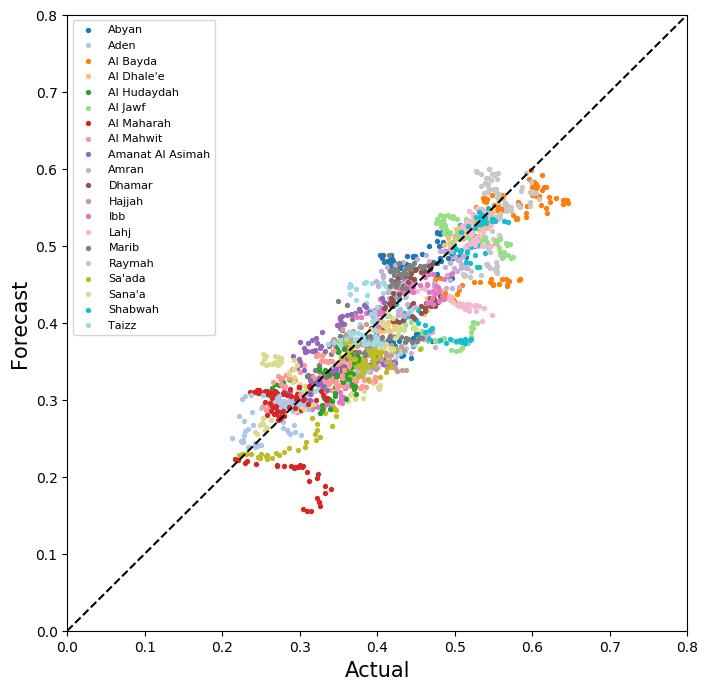

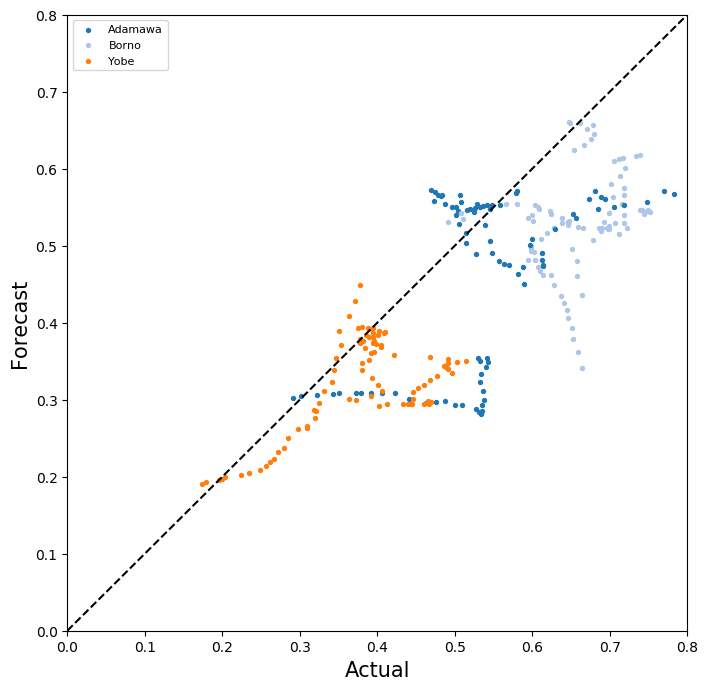

In [43]:
with plt.style.context("default"):
    for country in COUNTRIES_TO_CONSIDER:
        fig, axs = plt.subplots(figsize = (8, 8))
        axs.set_ylim([0, 1])
        axs.set_xlim([0, 1])
        # Add bisector.
        axs.plot(axs.get_xlim(), axs.get_ylim(), color = "black", linestyle = "--")

        for split_number in SPLITS_TO_USE:
            predictions = TOTAL_RESULTS[split_number]["prediction_sites"][[country]].copy()
            predictions = predictions.drop(["Naive", "lower_quantile", "upper_quantile"], axis = 1, level = 2)
            predictions = predictions/100

            def plot_scatter(group):
                gr = group[group.name[0]][group.name[1]]
                start, end = str(gr.index[0].date()), str(gr.index[-1].date())
                label = start + " - " + end
                gr.plot.scatter(x = "FCG", y = "Forecast", s = 8, color = plt.get_cmap("tab20")(predictions.columns.get_level_values(1).unique().get_loc(group.name[1])), ax = axs, label = group.name[1])

            predictions.groupby(axis = 1, level = [0, 1]).apply(plot_scatter)

            # Legend.
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            axs.legend(by_label.values(), by_label.keys(), loc = "best", prop = {"size": 8})
            axs.set_xlim(0, 0.8)
            axs.set_ylim(0, 0.8)

        axs.set_xlabel("Actual", fontsize = 15)
        axs.set_ylabel("Forecast", fontsize = 15)

        fig.savefig(dir_output_test + "/scatter2_%s.png" % country, bbox_inches = "tight", dpi = 300)

In [44]:
mStyles = ['s',"+","x","h","v","^","o"]

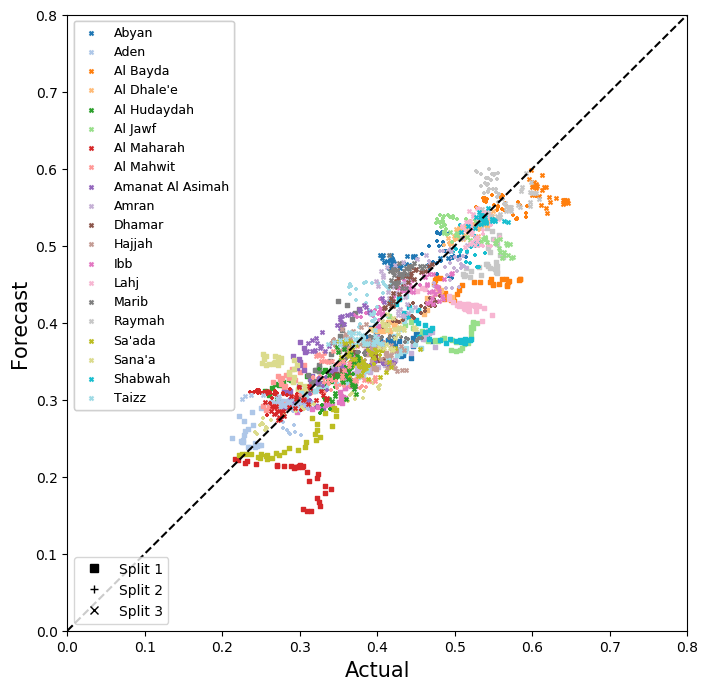

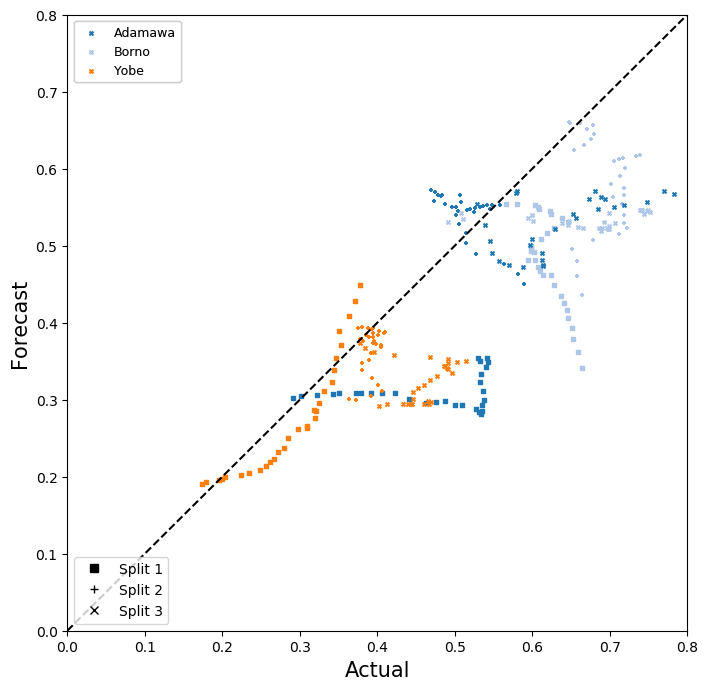

In [45]:
with plt.style.context("default"):
    for country in COUNTRIES_TO_CONSIDER:
        fig, axs = plt.subplots(figsize = (8, 8))
        axs.set_ylim([0, 1])
        axs.set_xlim([0, 1])
        # Add bisector.
        axs.plot(axs.get_xlim(), axs.get_ylim(), color = "black", linestyle = "--")

        for split_number in SPLITS_TO_USE:
            predictions = TOTAL_RESULTS[split_number]["prediction_sites"][[country]].copy()
            predictions = predictions.drop(["Naive", "lower_quantile", "upper_quantile"], axis = 1, level = 2)
            predictions = predictions/100

            def plot_scatter(group):
                gr = group[group.name[0]][group.name[1]]
                start, end = str(gr.index[0].date()), str(gr.index[-1].date())
                label = start + " - " + end
                gr.plot.scatter(x = "FCG", y = "Forecast", s = 8, marker = mStyles[split_number-1], color = plt.get_cmap("tab20")(predictions.columns.get_level_values(1).unique().get_loc(group.name[1])), ax = axs, label = group.name[1])

            predictions.groupby(axis = 1, level = [0, 1]).apply(plot_scatter)

            # Legend.
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            leg = plt.legend(by_label.values(), by_label.keys(), loc = "upper left", prop = {"size": 9})
            axs.add_artist(leg)
            h = [plt.plot([],[], color = "black", marker = mStyles[i], ls = "")[0] for i in range(len(SPLITS_TO_USE))]
            axs.legend(handles = h, labels = ["Split %d" % (i+1) for i in range(len(SPLITS_TO_USE))], loc = "lower left")
            axs.set_xlim(0, 0.8)
            axs.set_ylim(0, 0.8)

        axs.set_xlabel("Actual", fontsize = 15)
        axs.set_ylabel("Forecast", fontsize = 15)

        fig.savefig(dir_output_test + "/scatter3_%s.png" % country, bbox_inches = "tight", dpi = 300)

### Feature importance for prediction horizons: shap

#### Over the selected splits

In [46]:
SPLITS_IMPORTANCE = [3]

In [47]:
PREDICTION_HORIZONS = [1,5,15,20,25,30]

In [48]:
for split_number in SPLITS_IMPORTANCE:
    print("Split %d" % split_number)
    train, test = SPLITS[split_number]

    training_points = {"X": {h: [] for h in PREDICTION_HORIZONS}, 
                       "y": {h: [] for h in PREDICTION_HORIZONS}}

    for h in PREDICTION_HORIZONS:
        for country in COUNTRIES_TO_CONSIDER:
            # Select the subdataframe corresponding to the current country.
            train_country = train[country]
            # Define the second level of multi-sites (provinces level).
            provinces = train_country.columns.get_level_values(0).unique()
            for province in provinces:
                # Training samples.
                X_train = pd.read_csv(dir_data + "/train/%s/%s/X_train_split%d_h%d.csv" % (country, province, split_number, h), header = [0, 1], index_col = 0) 
                y_train = pd.read_csv(dir_data + "/train/%s/%s/y_train_split%d_h%d.csv" % (country, province, split_number, h), header = [0, 1], index_col = 0) 

                # Keep the features that are selected thanks to the previous training for the current prediction horizon and split..
                X_train = X_train[TOTAL_RESULTS[split_number]["models"][h][3]]

                # Flat the multi-index column names.
                #features_list = list()
                #for feature in X_train.columns:
                #    f1, f2 = feature[0], feature[1]
                #    features_list.append(f1 + " " + f2)

                #X_train.columns = features_list
                
                # Store information.
                training_points["X"][h].append(X_train)
                training_points["y"][h].append(y_train)

        training_points["X"][h] = pd.concat(training_points["X"][h]).reset_index(drop = True) 
        training_points["y"][h] = pd.concat(training_points["y"][h]).reset_index(drop = True) 
    
    # Get the shap importance over all the prediction horizons.
    for h in PREDICTION_HORIZONS:
        X = training_points["X"][h].copy()
        
        # load JS visualization code to notebook.
        shap.initjs()

        # Explain the model's predictions using SHAP keeping the trained model corresponding to the current split and prediction horizon.
        explainer = shap.TreeExplainer(TOTAL_RESULTS[split_number]["models"][h][0])
        shap_values = explainer.shap_values(X)
        
        print("Prediction horizon %d" % h)
        shap.summary_plot(shap_values, X, plot_size = (3, 5), show = False)
        # Save the figure.
        plt.savefig(dir_output_test + "/feature_importance_split%d_h%d.png" % (split_number, h), bbox_inches = "tight", dpi = 300)
        plt.close()

Split 3


C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\shap\explainers\tree.py:114: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.



Prediction horizon 1


Prediction horizon 5


Prediction horizon 15


Prediction horizon 20


Prediction horizon 25


Prediction horizon 30


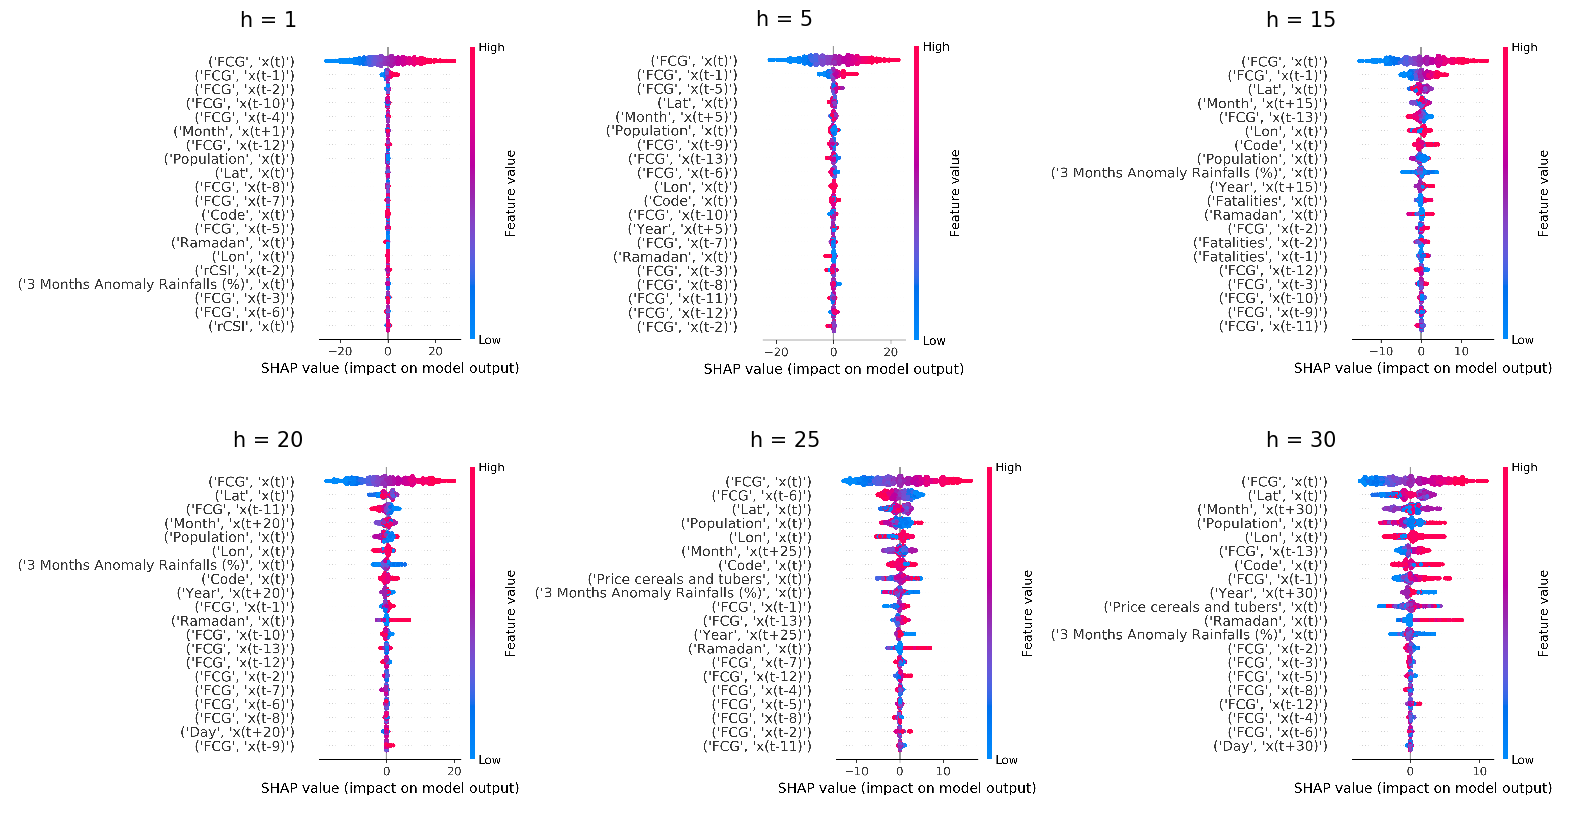

In [49]:
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize = (20, 10))
fig.subplots_adjust(wspace = 0., hspace = 0.2)
for i,h in enumerate(PREDICTION_HORIZONS):
    f = plt.imread(dir_output_test + "/feature_importance_split%d_h%d.png" % (3,h))
    ax = fig.add_subplot(gs[i])
    ax.imshow(f)
    ax.axis("off")
    ax.set_title("h = %d" % h, fontsize = 15)
    
fig.savefig(dir_output_test + "/feature_importance_split.png", bbox_inches = "tight", dpi = 300)

#### Retraining over all the available data using as parameters those obtained from last split.

In [50]:
PREDICTION_HORIZONS = [1,5,15,20,25,30]
LAST_EVALUATION_SPLIT = list(SPLITS.keys())[-1]

In [51]:
# Load the lags dictionary of the creator.
with open (dir_data + "/lags_dict", "rb") as fp:
    lags_dict_creator = pickle.load(fp)
    
with open (dir_data + "/global_variables", "rb") as fp:
    _, _, FEATURE_TIMES, _, _, STEP_BETWEEN_POINTS = pickle.load(fp)

In [52]:
training_points = {"X": {h: [] for h in PREDICTION_HORIZONS}, 
                   "y": {h: [] for h in PREDICTION_HORIZONS}}

for country in COUNTRIES_TO_CONSIDER:
    # Select the subdataframe corresponding to the current country.
    train_country = df[country]
    # Define the second level of multi-sites (provinces level).
    provinces = train_country.columns.get_level_values(0).unique()
    for province in provinces:
        creator = LagsCreator(train_country[province], lags_dictionary = lags_dict_creator, target = TARGET, delay = True)
        for h in PREDICTION_HORIZONS:
            # Training samples.
            X_train, y_train, _, _ = creator.to_supervised(h = h, step = STEP_BETWEEN_POINTS, single_step = True, 
                                                           return_dataframe = True, feature_time = FEATURE_TIMES, 
                                                           dtype = float)

            # Keep the features that are selected thanks to the the last available evaluation split.
            X_train = X_train[TOTAL_RESULTS[LAST_EVALUATION_SPLIT]["models"][h][3]]

            # Store information.
            training_points["X"][h].append(X_train)
            training_points["y"][h].append(y_train)

for h in PREDICTION_HORIZONS:
    training_points["X"][h] = pd.concat(training_points["X"][h]).reset_index(drop = True) 
    training_points["y"][h] = pd.concat(training_points["y"][h]).reset_index(drop = True) 

In [53]:
# Get the shap importance over all the prediction horizons.
for h in PREDICTION_HORIZONS:
    X = training_points["X"][h].copy()
    y = training_points["y"][h].copy()
    
    parameter_names = parameter_names_model + parameter_names_indicator
    best_parameters = best_result.loc[LAST_EVALUATION_SPLIT][parameter_names].astype(float)
    best_parameter_model = best_parameters[parameter_names_model]
    
    # Select best model parameters.
    best_parameter_model_h = dict(best_parameter_model.loc[h])
    # Convert to int type the float numbers that are integers.
    best_parameter_model_h = {k: int(v) if v.is_integer() else v for k,v in best_parameter_model_h.items()}

    # Model.
    model = xgb.XGBRegressor(**best_parameter_model_h, objective = "reg:squarederror")
    model.fit(X, y)

    # load JS visualization code to notebook.
    shap.initjs()

    # Explain the model's predictions using SHAP keeping the trained model corresponding to the current split and prediction horizon.
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    print("Prediction horizon %d" % h)
    shap.summary_plot(shap_values, X, plot_size = (3, 5), show = False)
    # Save the figure.
    plt.savefig(dir_output_test + "/feature_importance_h%d.png" % h, bbox_inches = "tight", dpi = 300)
    plt.close()

Prediction horizon 1


Prediction horizon 5


Prediction horizon 15


Prediction horizon 20


Prediction horizon 25


Prediction horizon 30


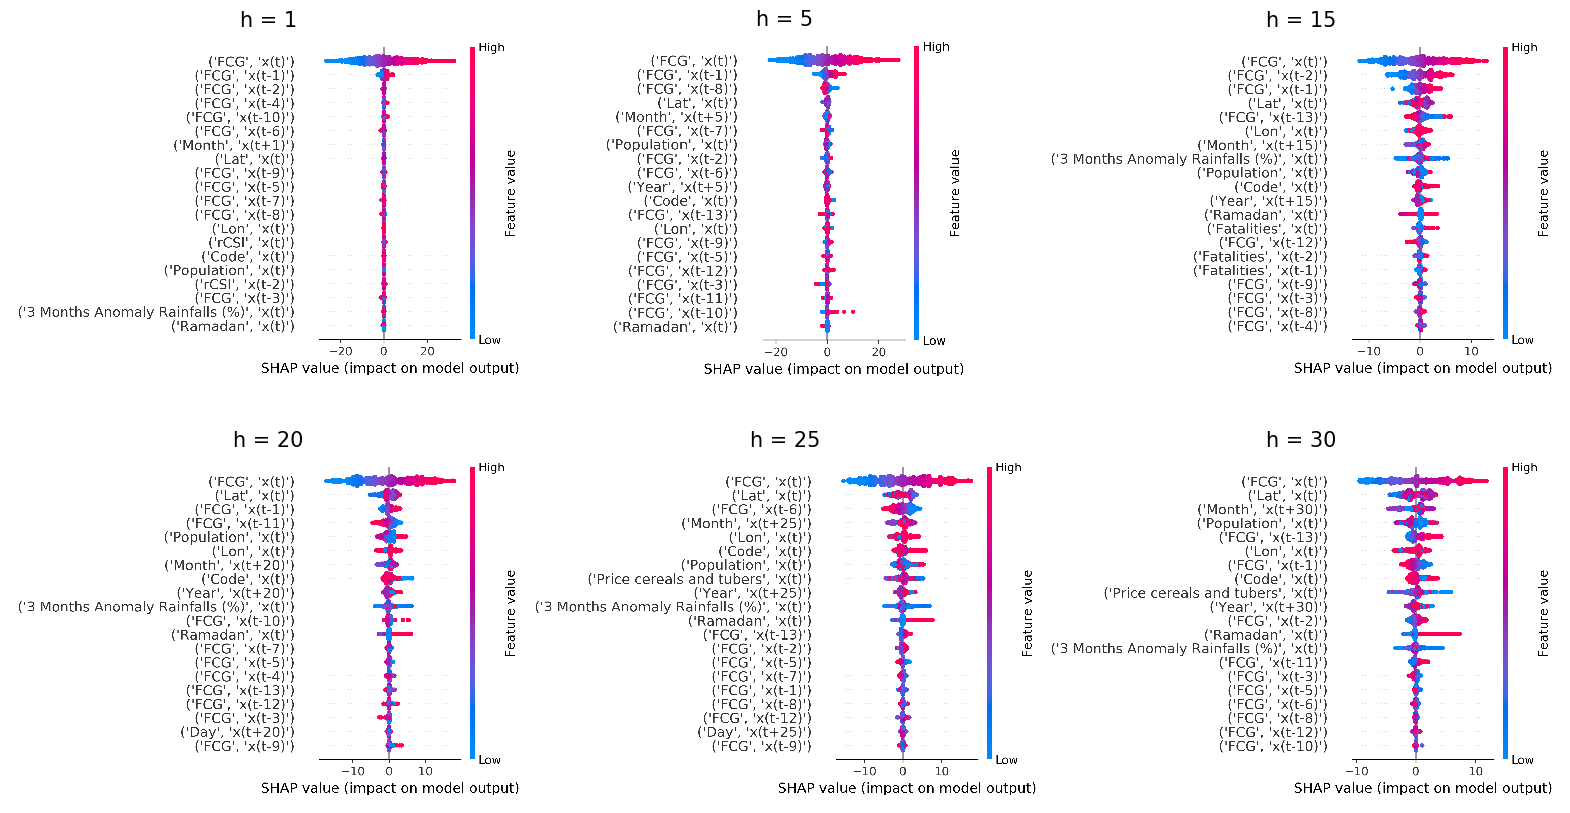

In [54]:
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize = (20, 10))
fig.subplots_adjust(wspace = 0., hspace = 0.2)
for i,h in enumerate(PREDICTION_HORIZONS):
    f = plt.imread(dir_output_test + "/feature_importance_h%d.png" % h)
    ax = fig.add_subplot(gs[i])
    ax.imshow(f)
    ax.axis("off")
    ax.set_title("h = %d" % h, fontsize = 15)
    
fig.savefig(dir_output_test + "/feature_importance.png", bbox_inches = "tight", dpi = 300)

In [55]:
def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop("index",axis = 1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient.
    corr_df.columns  = ["Features", "Corr"]
    corr_df["Sign"] = np.where(corr_df["Corr"] > 0, "red", "blue")

    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ["Features", "SHAP_abs"]
    k2 = k.merge(corr_df,left_on = "Features",right_on = "Features", how = "inner")
    k2 = k2.sort_values(by = "SHAP_abs", ascending = True)
    
    return k2

Prediction horizon 1


C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\shap\explainers\tree.py:114: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.



Prediction horizon 5


C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\shap\explainers\tree.py:114: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.



Prediction horizon 15


C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\shap\explainers\tree.py:114: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.



Prediction horizon 20


C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\shap\explainers\tree.py:114: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.



Prediction horizon 25


C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\shap\explainers\tree.py:114: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.



Prediction horizon 30


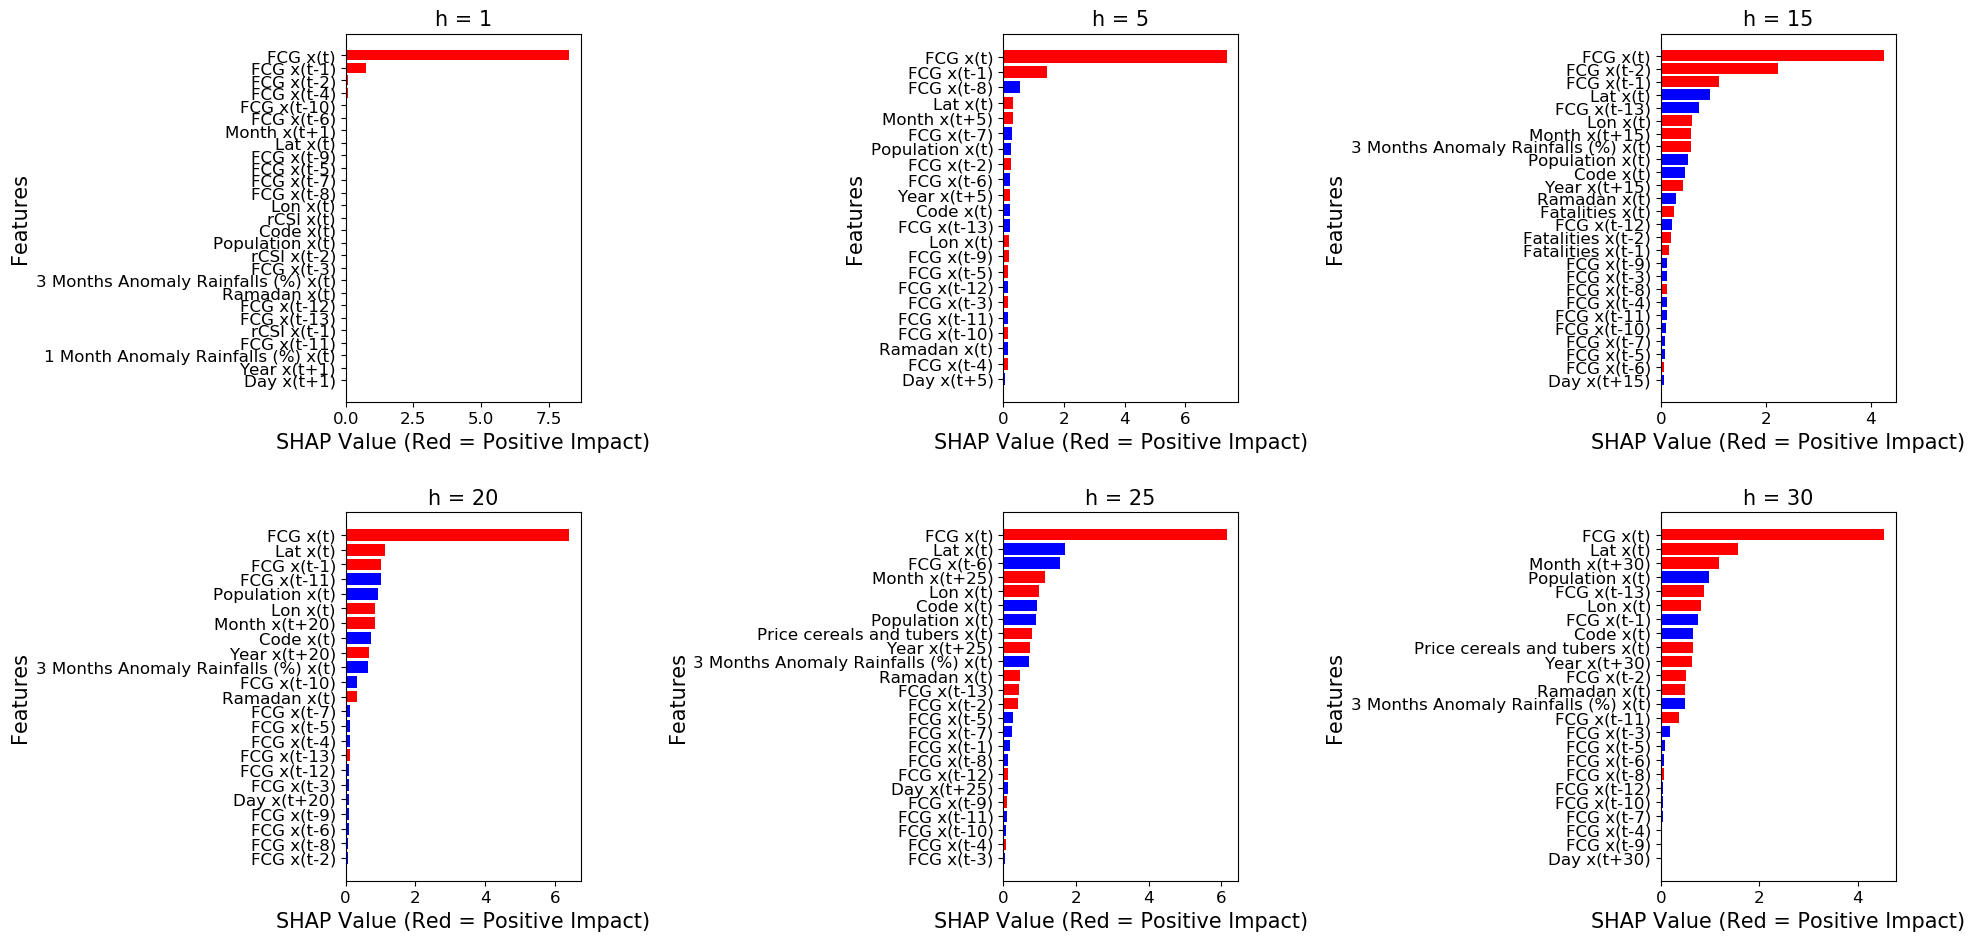

In [56]:
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize = (20, 11))
fig.subplots_adjust(wspace = 1.8, hspace = 0.3)

# Get the shap importance over all the prediction horizons.
for i,h in enumerate(PREDICTION_HORIZONS):
    X = training_points["X"][h].copy()
    y = training_points["y"][h].copy()
    
    # Flat the multi-index column names.
    features_list = list()
    for feature in X.columns:
        f1, f2 = feature[0], feature[1]
        features_list.append(f1 + " " + f2)

    X.columns = features_list
    
    parameter_names = parameter_names_model + parameter_names_indicator
    best_parameters = best_result.loc[LAST_EVALUATION_SPLIT][parameter_names].astype(float)
    best_parameter_model = best_parameters[parameter_names_model]
    
    # Select best model parameters.
    best_parameter_model_h = dict(best_parameter_model.loc[h])
    # Convert to int type the float numbers that are integers.
    best_parameter_model_h = {k: int(v) if v.is_integer() else v for k,v in best_parameter_model_h.items()}

    # Model.
    model = xgb.XGBRegressor(**best_parameter_model_h, objective = "reg:squarederror")
    model.fit(X, y)

    # load JS visualization code to notebook.
    shap.initjs()

    # Explain the model's predictions using SHAP keeping the trained model corresponding to the current split and prediction horizon.
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    print("Prediction horizon %d" % h)
    k2 = ABS_SHAP(shap_values, X) 

    colorlist = k2["Sign"]
    ax = fig.add_subplot(gs[i])
    ax.barh(k2["Features"], width = k2["SHAP_abs"], color = colorlist)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)", fontsize = 15)
    ax.set_ylabel("Features", fontsize = 15)
    ax.set_title("h = %d" % h, fontsize = 15)
    ax.tick_params(labelsize = 12)
    
fig.savefig(dir_output_test + "/feature_importance_barplot.png", bbox_inches = "tight", dpi = 300)